## Import Libraries

In [478]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

from sklearn.impute import KNNImputer # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold # type: ignore
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # type: ignore
from sklearn.neighbors import KNeighborsRegressor # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from xgboost import XGBRegressor # type: ignore

from statsmodels.stats.outliers_influence import variance_inflation_factor # type: ignore
import scikitplot as skplt # type: ignore

## Set Parameters

In [544]:
k = 5
ratio = 0.2
pd.set_option('display.width', 1000)  # Set a wider display width for better readability
pd.options.display.float_format = '{:.1f}'.format

## Data Processing

### Loading Data

Note that some continuous values here equal to 0, which is abnormal. We should also treat such samples as missing values.

In [585]:
path = '../data/training.csv'
df = pd.read_csv(path, header=0)
path_new = '../data/offers.csv'
df_new = pd.read_csv(path_new, header=0)
df_new = df_new.drop(columns='Offers')
display(df.head(5))
df['Profit'] = df['Retail'] - df['Price']
continuous_vars = df.select_dtypes(include=[np.number]).columns.to_list()  # list_continous_vars
exclude = ['id', 'Vendor', 'Price', 'Retail', 'LogPrice', 'LogRetail', 'Profit']  # Move to later
for var in exclude:
    continuous_vars.remove(var)
for name in continuous_vars:  # Comments!!!
    index = df[df[name] == 0].index
    for i in index:
        df[name].loc[i] = np.NaN

,id,Carats,Cert,Clarity,Color,Cut,Depth,Known_Conflict_Diamond,Measurements,Polish,Regions,Shape,Symmetry,Table,Vendor,Price,Retail,LogPrice,LogRetail
0,1,0.4,NaN,SI1,L,,65.4,False,4.65x4.62x3.03,Very good,Other/Unknown,Princess,Good,NaN,1,430,850,6.1,6.7
1,2,0.4,AGSL,SI2,L,,61.7,False,4.85x4.79x2.98,Excellent,Russia,Marquise,Very good,NaN,1,560,920,6.3,6.8
2,3,0.4,AGSL,SI1,L,,64.0,False,4.66x4.63x2.97,Excellent,South Africa,Round,Excellent,57.0,1,560,575,6.3,6.4
3,4,0.4,AGSL,SI2,L,,62.7,False,4.71x4.69x2.95,Very good,Botswana,Round,Very good,58.0,1,560,825,6.3,6.7
4,5,0.4,AGSL,SI1,L,,63.0,False,4.71x4.68x2.96,Excellent,Botswana,Round,Very good,58.0,1,580,890,6.4,6.8


c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Data Description

In [383]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8050 entries, 0 to 8049
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      8050 non-null   int64  
 1   Carats                  8050 non-null   float64
 2   Cert                    7498 non-null   object 
 3   Clarity                 8050 non-null   object 
 4   Color                   8050 non-null   object 
 5   Cut                     8050 non-null   object 
 6   Depth                   6605 non-null   float64
 7   Known_Conflict_Diamond  8050 non-null   bool   
 8   Measurements            8050 non-null   object 
 9   Polish                  8050 non-null   object 
 10  Regions                 8050 non-null   object 
 11  Shape                   8050 non-null   object 
 12  Symmetry                8050 non-null   object 
 13  Table                   5510 non-null   float64
 14  Vendor                  8050 non-null   

For the training dataset, we have 8050 samples of diamonds in total.

Most features don't have missing values.

The features containing missing values are Cert, Depth and Table.

In [384]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683 entries, 0 to 2682
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2683 non-null   int64  
 1   Carats                  2683 non-null   float64
 2   Cert                    2470 non-null   object 
 3   Clarity                 2683 non-null   object 
 4   Color                   2683 non-null   object 
 5   Cut                     2683 non-null   object 
 6   Depth                   2186 non-null   float64
 7   Known_Conflict_Diamond  305 non-null    object 
 8   Measurements            2683 non-null   object 
 9   Polish                  2683 non-null   object 
 10  Regions                 2683 non-null   object 
 11  Shape                   2683 non-null   object 
 12  Symmetry                2683 non-null   object 
 13  Table                   1827 non-null   float64
 14  Vendor                  2683 non-null   

For the testing data (that's how we will call the data for further prediction), we have 2683 samples of diamonds in total.

Most features don't have missing values.

The features containing missing values are Cert, Depth, Table and Known_Conflict_Diamond.

The first three features mentioned above are in accord with the training dataset.

The feature Known_Conflict_Diamond has a lot of missing values, so it needs further consideration.

We can also get the statistical description of the training and testing datasets.

In [385]:
df.drop(columns='id').describe()

,Carats,Depth,Table,Vendor,Price,Retail,LogPrice,LogRetail,Profit
count,8050.000000,6605.000000,5510.000000,8050.000000,8.050000e+03,8.050000e+03,8050.000000,8050.000000,8050.000000
mean,1.265807,61.770098,58.046642,2.050435,1.508101e+04,2.149478e+04,8.803274,9.127529,6413.768944
std,0.894574,1.387571,1.957110,0.983876,3.564261e+04,5.146239e+04,1.225854,1.282771,20326.028963
min,0.400000,50.800000,46.000000,1.000000,3.950000e+02,4.500000e+01,5.978886,3.806662,-673680.000000
25%,0.700000,61.000000,57.000000,1.000000,2.690000e+03,3.571250e+03,7.897296,8.180671,1090.000000
50%,1.040000,62.000000,58.000000,2.000000,7.050000e+03,1.033500e+04,8.860783,9.243291,3480.000000
75%,1.510000,62.600000,59.000000,3.000000,1.466000e+04,2.052000e+04,9.592878,9.929155,6593.750000
max,11.920000,69.700000,69.000000,4.000000,1.087785e+06,1.675190e+06,13.899654,14.331437,587405.000000


In [386]:
df_new.drop(columns='id').describe()

,Carats,Depth,Table,Vendor
count,2683.000000,2186.000000,1827.000000,2683.000000
mean,1.264845,61.781656,58.104324,2.045099
std,0.893580,1.389693,2.081220,0.984886
min,0.400000,56.000000,43.000000,1.000000
25%,0.700000,60.925000,57.000000,1.000000
50%,1.050000,62.000000,58.000000,2.000000
75%,1.505000,62.600000,59.000000,3.000000
max,10.050000,67.300000,70.000000,4.000000


### Missing Values Processing

#### Cert

First we examine the missing values of 'Cert' for the training dataset.

In [387]:
name = 'Cert'
cert = df[name]
cert = list(set(cert))
try:
    cert.remove(np.nan)
except ValueError:
    pass
number = len(df[name].loc[df[name].isna()])
print(f'There are {number} rows with missing values of column {name}.')
print(f'The number of unique values within the column {name} is {len(cert)}.')
print(f'The unique values within the column {name} are {cert}.')

There are 552 rows with missing values of column Cert.
The number of unique values within the column Cert is 2.
The unique values within the column Cert are ['AGSL', 'GemEx'].


Then we examine the missing value of 'Cert' for the testing dataset.

In [388]:
name = 'Cert'
cert = df_new[name]
cert = list(set(cert))
try:
    cert.remove(np.nan)
except ValueError:
    pass
number = len(df_new[name].loc[df_new[name].isna()])
print(f'There are {number} rows with missing values of column {name}.')
print(f'The number of unique values within the column {name} is {len(cert)}.')
print(f'The unique values within the column {name} are {cert}.')

There are 213 rows with missing values of column Cert.
The number of unique values within the column Cert is 2.
The unique values within the column Cert are ['AGSL', 'GemEx'].


We fill the missing values with 'Unknown', and then see the general result. We mainly focus on the training dataset, since it contains the monetary information.

In [389]:
df['Cert'] = df['Cert'].fillna('Unknown')
df_group = df.groupby(by='Cert').agg({
    'id': 'count',
    'Profit': ['max', 'min', 'mean', 'std'],
    'Retail': ['max', 'min', 'mean', 'std'],
    'Price': ['max', 'min', 'mean', 'std']
})
df_group.columns = ['count', 'MaxProfit', 'MinProfit', 'AvgProfit', 'StdProfit', 'MaxRetail', 'MinRetail', 'AvgRetail', 'StdRetail', 'MaxPrice', 'MinPrice', 'AvgPrice', 'StdPrice']
df_group

,count,MaxProfit,MinProfit,AvgProfit,StdProfit,MaxRetail,MinRetail,AvgRetail,StdRetail,MaxPrice,MinPrice,AvgPrice,StdPrice
Cert,,,,,,,,,,,,,
AGSL,6973,587405,-673680,6532.980066,20769.625982,1675190,45,21752.096659,52341.080447,1087785,395,15219.116593,36392.682852
GemEx,525,107995,-26650,5847.990476,11454.548128,307990,90,18889.076190,32855.915484,199995,605,13041.085714,22438.936168
Unknown,552,403145,-21995,5445.969203,21229.213350,875780,150,20722.545290,54662.188499,472635,430,15276.576087,36282.104878


In [390]:
df_new['Cert'] = df_new['Cert'].fillna('Unknown')
df_new_group = df_new.groupby(by='Cert').agg({
    'id': 'count'
})
df_new_group.columns = ['count']
df_new_group

,count
Cert,
AGSL,2265
GemEx,205
Unknown,213


We should also treat Cert as dummy variables.

Note: Here we can use the function get_dummies() to generate dummy variables automatically.

In [391]:
# for cert in ['AGSL', 'GemEx', 'Unknown']:
#     col_name = f'Cert_{cert}'
#     col = [1 if x == cert else 0 for x in df['Cert'].to_list()]
#     df[col_name] = col
#     col_new = [1 if x == cert else 0 for x in df_new['Cert'].to_list()]
#     df_new[col_name] = col_new

We can check the violin plots for the distribution of profit within each Cert category.

For AGSL diamonds, the zone bounded by mean value with one standard deviation contains 94.44 of the data.
For GemEx diamonds, the zone bounded by mean value with one standard deviation contains 92.19 of the data.
For Unknown diamonds, the zone bounded by mean value with one standard deviation contains 96.38 of the data.


([<matplotlib.axis.XTick at 0x1e7a8fe1220>,
 [Text(0, 0, 'AGSL'), Text(1, 0, 'GemEx'), Text(2, 0, 'Unknown')])

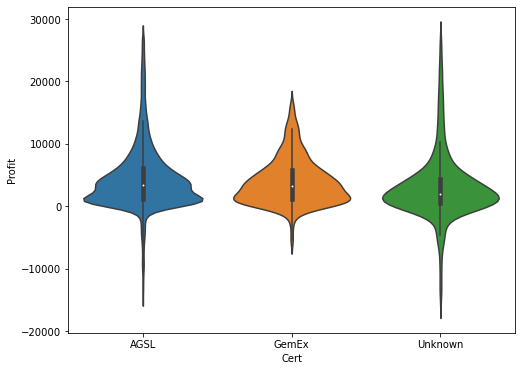

In [392]:
profits = []
for cert in ['AGSL', 'GemEx', 'Unknown']:
    df_sub = df_group[df_group.index == cert]
    profit = df[df['Cert'] == cert]['Profit'].to_list()
    min_val, max_val = float(df_sub['AvgProfit']) - float(df_sub['StdProfit']), float(df_sub['AvgProfit']) + float(df_sub['StdProfit'])
    sub_list = [x for x in profit if min_val <= x and x <= max_val]
    x = '%.2f' % (len(sub_list) / len(profit) * 100)
    print(f'For {cert} diamonds, the zone bounded by mean value with one standard deviation contains {x} of the data.')
    profits.append(sub_list)
plt.figure(figsize=(8, 6))
sns.violinplot(data=profits)
plt.xlabel('Cert')
plt.ylabel('Profit')
plt.xticks(ticks=[0, 1, 2], labels=['AGSL', 'GemEx', 'Unknown'])

From the above results, we have some insightful findings.
1. The value of Cert has correlation with the pricing and profits of diamonds. The average price is ranked as AGSL>Unknown>GemEx, while the average profit is ranked as AGSL>GemEX>Unknown. Generally speaking, diamonds from AGSL tend to get the highest price and generate the largest profit, while diamonds from GemEx or Unknown tend to be less valuable on average.
2. For the violin plots, we only consider the data with profits in [$\mu$-$\sigma$, $\mu$+$\sigma$], which contains the majority of data (more than 90%). Otherwise, the violin plots will be highly condensed and can't be interpreted. From the violin plots, we can see that plots of diamonds with AGSL Cert or Unknown Cert have a longer shape, which means more fluctuation in price. In contrast, the plot of diamonds with GemEx Cert has a shorter shape, which means such diamonds are more stable in profit.
3. The average retail and price of GemEx is lower than that of AGSL and Unknown, which means that GemEx may focus on smaller diamond business with a more conservative style, while AGSL and Unknown focus on higher-priced diamonds.

#### Depth

First we examine the missing values of 'Depth' for the training dataset.

In [393]:
name = 'Depth'
number = len(df[name].loc[df[name].isna()])
print(f'There are {number} rows with missing values of column {name}.')

There are 1445 rows with missing values of column Depth.


Then we examine the missing value of 'Depth' for the testing dataset.

In [394]:
name = 'Depth'
number = len(df_new[name].loc[df_new[name].isna()])
print(f'There are {number} rows with missing values of column {name}.')

There are 497 rows with missing values of column Depth.


Then we analyze the correlation of Depth between retail/price/profit.

In [395]:
df_drop = df.dropna(axis=0, subset=['Depth'], how='any')
for item in ['Retail', 'Price', 'Profit']:
    corr = np.corrcoef(df_drop['Depth'], df_drop[item])[0, 1]
    x = '%.4f' % corr
    print(f'The correlation between Depth and {item} is {x}.')

The correlation between Depth and Retail is -0.0875.
The correlation between Depth and Price is -0.0889.
The correlation between Depth and Profit is -0.0639.


From the above results, we can see the correlation between Depth and Monetary Variables is negative and not statiscally significant.

Therefore, we can use imputation methods to fill in the missing values, which won't remarkably interfere with the final pricing.

Here we use KNN imputer and calculate the mean value of depth to fill the missing values.

In [586]:
knn = KNNImputer(n_neighbors=k)
imputed_df = knn.fit_transform(df[continuous_vars])
imputed_df = pd.DataFrame(imputed_df, columns=continuous_vars)
df['Depth'] = imputed_df['Depth']

imputed_df_new = knn.transform(df_new[continuous_vars])
imputed_df_new = pd.DataFrame(imputed_df_new, columns=continuous_vars)
df_new['Depth'] = imputed_df_new['Depth']

([<matplotlib.axis.XTick at 0x1e798616a30>,
 [Text(0, 0, 'Training'), Text(1, 0, 'Testing')])

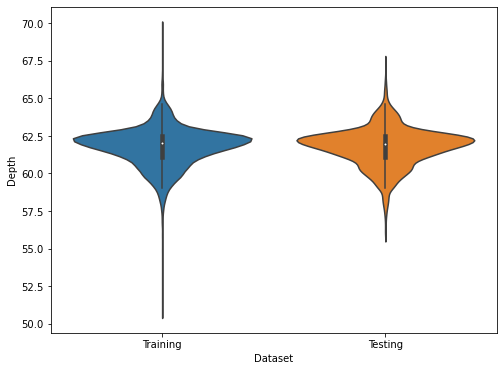

In [397]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=[df['Depth'], df_new['Depth']])
plt.xlabel('Dataset')
plt.ylabel('Depth')
plt.xticks(ticks=[0, 1], labels=['Training', 'Testing'])

From the violin plot, we can see that the training and testing datasets have similar mean values of Depth.

The distribution of Depth are also both similar to normal distribution.

But the training dataset has more extreme values of Depth than the testing dataset, which may implicate a slightly higher noise.

#### Table

First we examine the missing values of 'Table' for the training dataset.

In [398]:
name = 'Table'
number = len(df[name].loc[df[name].isna()])
print(f'There are {number} rows with missing values of column {name}.')

There are 2540 rows with missing values of column Table.


Then we examine the missing value of 'Table' for the testing dataset.

In [399]:
name = 'Table'
number = len(df_new[name].loc[df_new[name].isna()])
print(f'There are {number} rows with missing values of column {name}.')

There are 856 rows with missing values of column Table.


Then we analyze the correlation of Table between retail/price/profit.

In [400]:
df_drop = df.dropna(axis=0, subset=['Table'], how='any')
for item in ['Retail', 'Price', 'Profit']:
    corr = np.corrcoef(df_drop['Table'], df_drop[item])[0, 1]
    x = '%.4f' % corr
    print(f'The correlation between Table and {item} is {x}.')

The correlation between Table and Retail is 0.0026.
The correlation between Table and Price is 0.0032.
The correlation between Table and Profit is 0.0013.


From the above results, we can see the correlation between Table and Monetary Variables is positive and not statiscally significant. (Note that the lower correlation than depth may be partially due to the massive missing values.)

Therefore, we can use imputation methods to fill in the missing values, which won't remarkably interfere with the final pricing.

Here we use KNN imputer and calculate the mean value of table to fill the missing values.

In [401]:
df['Table'] = imputed_df['Table']
df_new['Table'] = imputed_df_new['Table']

([<matplotlib.axis.XTick at 0x1e79aea4dc0>,
 [Text(0, 0, 'Training'), Text(1, 0, 'Testing')])

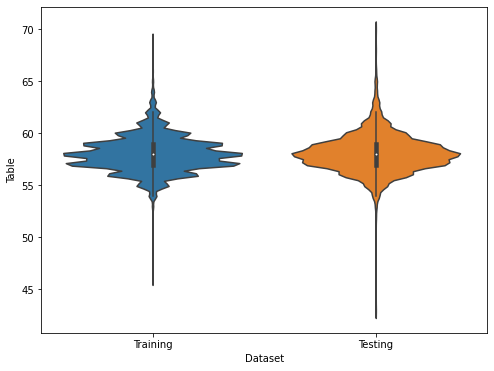

In [402]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=[df['Table'], df_new['Table']])
plt.xlabel('Dataset')
plt.ylabel('Table')
plt.xticks(ticks=[0, 1], labels=['Training', 'Testing'])

From the violin plot, we can see that the training and testing datasets have similar mean values of Table.

The general shape of distribution of Table are also both similar to normal distribution.

But the training dataset has more fluctuation in the shape of distribution than the testing dataset, which may implicate a higher randomized noise.

#### Known_Conflict_Diamond

First we examine the missing values of 'Known_Conflict_Diamond' in both the training and testing datasets.

In [403]:
name = 'Known_Conflict_Diamond'
known = df[name]
known = list(set(known))
try:
    known.remove(np.nan)
except ValueError:
    pass
number = len(df[name].loc[df[name].isna()])
print(f'There are {number} rows with missing values of column {name}.')
print(f'The number of unique values within the column {name} is {len(known)}.')
print(f'The unique values within the column {name} are {known}.')

There are 0 rows with missing values of column Known_Conflict_Diamond.
The number of unique values within the column Known_Conflict_Diamond is 2.
The unique values within the column Known_Conflict_Diamond are [False, True].


In [404]:
name = 'Known_Conflict_Diamond'
known = df_new[name]
known = list(set(known))
try:
    known.remove(np.nan)
except ValueError:
    pass
number = len(df_new[name].loc[df_new[name].isna()])
print(f'There are {number} rows with missing values of column {name}.')
print(f'The number of unique values within the column {name} is {len(known)}.')
print(f'The unique values within the column {name} are {known}.')

There are 2378 rows with missing values of column Known_Conflict_Diamond.
The number of unique values within the column Known_Conflict_Diamond is 2.
The unique values within the column Known_Conflict_Diamond are [True, False].


This is a quite tough feature with missing values to process, since only the testing dataset contains a lot of missing values.

Then we examine the two different categories of diamonds in the training dataset.

In [405]:
df_group = df.groupby(by='Known_Conflict_Diamond').agg({
    'id': 'count',
    'Profit': ['max', 'min', 'mean', 'std'],
    'Retail': ['max', 'min', 'mean', 'std'],
    'Price': ['max', 'min', 'mean', 'std']
})
df_group.columns = ['count', 'MaxProfit', 'MinProfit', 'AvgProfit', 'StdProfit', 'MaxRetail', 'MinRetail', 'AvgRetail', 'StdRetail', 'MaxPrice', 'MinPrice', 'AvgPrice', 'StdPrice']
df_group

,count,MaxProfit,MinProfit,AvgProfit,StdProfit,MaxRetail,MinRetail,AvgRetail,StdRetail,MaxPrice,MinPrice,AvgPrice,StdPrice
Known_Conflict_Diamond,,,,,,,,,,,,,
False,7741,587405,-41255,7232.073376,18292.866380,1675190,380,22257.513241,52313.768802,1087785,395,15025.439866,34860.044640
True,309,-455,-673680,-14086.213592,44149.801266,109500,45,2386.957929,7468.435742,783180,500,16473.171521,51565.378625


It is quite obvious that Diamonds with label True have significantly lower price/retail/profit than those with label False.

It is not surprising since the illegal trade will diminish the value of diamonds.

Then we examine the propotion of two categories in the testing dataset.

In [406]:
df_new_group = df_new.groupby(by='Known_Conflict_Diamond').agg({
    'id': 'count',
})
df_new_group.columns = ['count']
df_new_group

,count
Known_Conflict_Diamond,
False,259
True,46


We can see that in both the training and testing dataset, Diamonds with label False are much more in quantity than those with label True. It seems appropriate for us to fill missing values with label False.

Actually, such method does is reasonable for the following two reasons.

1. Label False accounts for the majority of all the labels, so it makes sense just regarding the unknown diamonds as label False.
2. (This is the main reason!) Since the judgment of label True will remarkably decrease diamonds' value, we should be very careful when judging labels. In practice, we assume all diamonds have not been illegally traded (corresponding to label False), unless there is much evidence supporting the illegal trade. Similarly, for the diamonds with unknown labels, we should also label them as False, unless there is other evidence. It is comparable to hypothesis testing, where the null hypothesis is the diamonds are labelled True. Then the p-value here should be rather small, since only a few diamonds are labelled True. Therefore, we can reject the null hypothesis, which means that the diamonds should be labelled False.

In [407]:
df_new['Known_Conflict_Diamond'] = df_new['Known_Conflict_Diamond'].fillna(False)
df_new_group = df_new.groupby(by='Known_Conflict_Diamond').agg({
    'id': 'count'
})
df_new_group.columns = ['count']
df_new_group

,count
Known_Conflict_Diamond,
False,2637
True,46


### Other Variables Processing

Since we have processed the variables with missing values, we now focus on other variables.

Note that variables can be generally categorized as continuous and categorical.

#### Carats

First we check whether there are missing values (0 carats) in the datasets.

In [408]:
name = 'Carats'
number = len(df[name].loc[df[name].isna()])
print(f'There are {number} rows with missing values of column {name}. (Training Dataset)')
number = len(df_new[name].loc[df_new[name].isna()])
print(f'There are {number} rows with missing values of column {name}. (Testing Dataset)')

There are 0 rows with missing values of column Carats. (Training Dataset)
There are 0 rows with missing values of column Carats. (Testing Dataset)


Then we check the distribution of Carats for both the training and testing datasets.

([<matplotlib.axis.XTick at 0x1e79aef0eb0>,
 [Text(0, 0, 'Training'), Text(1, 0, 'Testing')])

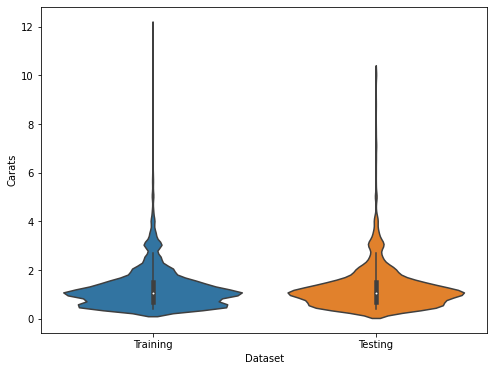

In [409]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=[df['Carats'], df_new['Carats']])
plt.xlabel('Dataset')
plt.ylabel('Carats')
plt.xticks(ticks=[0, 1], labels=['Training', 'Testing'])

From the violin plots, we can see that the training and testing datasets have similar distribution of Carats.

Most diamonds are around 1 Carats (probably 0.5~1.5 carats), while heavier diamonds are rarer.

Note that there exist a few outliers, which is much higher than the majority. This means that few diamonds are much heavier than the rest, thus having much higher values based on instinct.

Then we analyze the correlation of Carats between retail/price/profit.

In [410]:
for item in ['Retail', 'Price', 'Profit']:
    corr = np.corrcoef(df['Carats'], df[item])[0, 1]
    x = '%.4f' % corr
    print(f'The correlation between Carats and {item} is {x}.')

The correlation between Carats and Retail is 0.7163.
The correlation between Carats and Price is 0.7413.
The correlation between Carats and Profit is 0.5137.


We can see that the Carats is highly and positively correlated to the profit.

#### Clarity

First we check all the categories of Clarity.

There are 13 categories of Clarity.
All the categories are ['N', 'VS1', 'I3', 'None', 'SI2', 'VVS2', 'VVS1', 'SI1', 'I2', 'VS2', 'I1', 'FL', 'IF']


<BarContainer object of 13 artists>

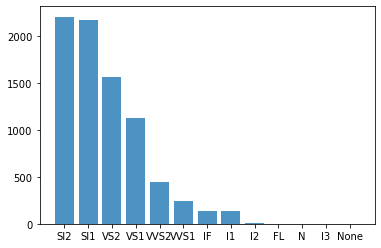

In [411]:
clarity = list(set(df['Clarity'].to_list()))
print(f'There are {len(clarity)} categories of Clarity.')
print(f'All the categories are {clarity}')
df_group = df.groupby('Clarity').agg({'id': 'count'})
df_group.columns = ['count']
df_group = df_group.sort_values(by=['count'], ascending=False)
plt.bar(df_group.index, df_group['count'], alpha=0.8)

Then we check the statistics of each different category.

In [412]:
df_group = df.groupby('Clarity').agg({
    'id': 'count',
    'Profit': ['max', 'min', 'mean', 'std'],
    'Retail': ['max', 'min', 'mean', 'std'],
    'Price': ['max', 'min', 'mean', 'std']
})
df_group.columns = ['count', 'MaxProfit', 'MinProfit', 'AvgProfit', 'StdProfit', 'MaxRetail', 'MinRetail', 'AvgRetail', 'StdRetail', 'MaxPrice', 'MinPrice', 'AvgPrice', 'StdPrice']
df_group

,count,MaxProfit,MinProfit,AvgProfit,StdProfit,MaxRetail,MinRetail,AvgRetail,StdRetail,MaxPrice,MinPrice,AvgPrice,StdPrice
Clarity,,,,,,,,,,,,,
FL,2,224305,88810,156557.500000,95809.433317,640875,253740,447307.500000,273745.783735,416570,164930,290750.000000,177936.350418
I1,132,11795,-1200,2213.598485,2195.600243,33695,155,6545.037879,6405.454751,24035,580,4331.439394,4475.258896
I2,13,3770,270,1602.692308,1271.550260,19495,1380,5024.615385,5129.438103,15725,845,3421.923077,4048.989863
I3,1,1995,1995,1995.000000,NaN,6190,6190,6190.000000,NaN,4195,4195,4195.000000,NaN
IF,137,587405,-673680,23475.328467,98308.045066,1675190,1195,83908.394161,208098.122031,1087785,780,60433.065693,146601.786957
N,2,1365,1005,1185.000000,254.558441,2800,1980,2390.000000,579.827561,1435,975,1205.000000,325.269119
None,1,5390,5390,5390.000000,NaN,15400,15400,15400.000000,NaN,10010,10010,10010.000000,NaN
SI1,2168,188965,-73500,5075.493542,10147.325462,538905,45,17257.022601,28430.425560,407830,430,12181.529059,20191.777000
SI2,2208,162865,-296215,4275.538949,10703.453548,465330,90,14638.992301,22834.334328,352210,395,10363.453351,17037.507452


From the above result, we can see there are several major categories (like SI/VS/VVS) with lots of samples.

There are also several minor categories (like I/N/FL) with only few samples.

Categories with the same characters tend to have similar average profit.

High profit clarity category: FL, IF, VVS2

Low profit clarity category: N, I1/I2/I3

In [413]:
df_new_group = df_new.groupby('Clarity').agg({
    'id': 'count',
})
df_new_group.columns = ['count']
df_new_group

,count
Clarity,
I1,49
I2,2
I3,2
IF,52
SI1,717
SI2,782
VS1,386
VS2,489
VVS1,81


Here we choose not to include those categories with few samples into other major categories. (E.g. Include I3 into I1)

Because the sample from these minor categories are so scarce that we can't conclude their average price/retail/benefit is typical.

So we can't conclude that these minor categories are similar to major categories in terms of price/retail/benefit. We may just leave them alone.

#### Color

First we check all the categories of Color.

There are 32 categories of Color.
All the categories are ['Fly', 'Gy', 'Fiy', 'Fvyellow', 'Fdpink', 'J', 'Q-r', 'I', 'Ffcdbrown', 'Ffcy', 'Lb', 'Ffcly', 'Flyellow', 'K', 'P', 'M', 'Ffcg', 'N', 'L', 'O-p', 'G', 'F', 'U', 'Ffg', 'Fiyellow', 'E', 'S', 'D', 'W', 'H', 'Fdy', 'Fyellow']


<BarContainer object of 32 artists>

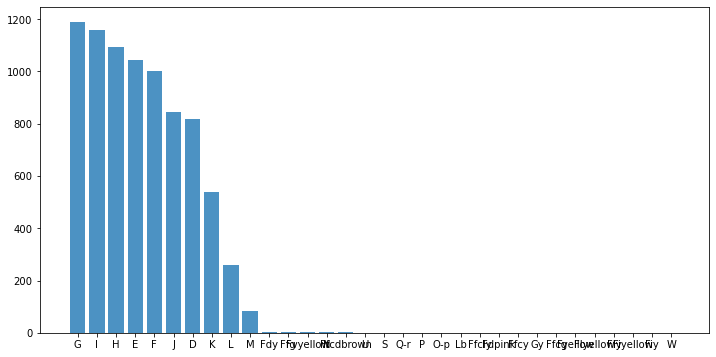

In [414]:
color = list(set(df['Color'].to_list()))
print(f'There are {len(color)} categories of Color.')
print(f'All the categories are {color}')
df_group = df.groupby('Color').agg({'id': 'count'})
df_group.columns = ['count']
df_group = df_group.sort_values(by=['count'], ascending=False)
plt.figure(figsize=(12,6))
plt.bar(df_group.index, df_group['count'], alpha=0.8)

Then we check the statistics of each different category.

In [415]:
df_group = df.groupby('Color').agg({
    'id': 'count',
    'Profit': ['max', 'min', 'mean', 'std'],
    'Retail': ['max', 'min', 'mean', 'std'],
    'Price': ['max', 'min', 'mean', 'std']
})
df_group.columns = ['count', 'MaxProfit', 'MinProfit', 'AvgProfit', 'StdProfit', 'MaxRetail', 'MinRetail', 'AvgRetail', 'StdRetail', 'MaxPrice', 'MinPrice', 'AvgPrice', 'StdPrice']
df_group

,count,MaxProfit,MinProfit,AvgProfit,StdProfit,MaxRetail,MinRetail,AvgRetail,StdRetail,MaxPrice,MinPrice,AvgPrice,StdPrice
Color,,,,,,,,,,,,,
D,816,467855,-41630,10751.574755,30868.042896,1047880,190,33025.104167,79260.392735,681120,455,22273.529412,50054.380697
E,1042,286990,-145630,6159.961612,17122.976049,882415,45,21485.686180,49380.719859,595425,500,15325.724568,35597.818157
F,1000,587405,-40610,7213.980000,23998.410329,1675190,135,22601.420000,68419.094477,1087785,635,15387.440000,44905.586371
Fdpink,1,6065,6065,6065.000000,NaN,15510,15510,15510.000000,NaN,9445,9445,9445.000000,NaN
Fdy,2,1365,1005,1185.000000,254.558441,2800,1980,2390.000000,579.827561,1435,975,1205.000000,325.269119
Ffcdbrown,2,2590,630,1610.000000,1385.929291,5710,1585,3647.500000,2916.815472,3120,955,2037.500000,1530.886181
Ffcg,1,5905,5905,5905.000000,NaN,83320,83320,83320.000000,NaN,77415,77415,77415.000000,NaN
Ffcly,1,1125,1125,1125.000000,NaN,2655,2655,2655.000000,NaN,1530,1530,1530.000000,NaN
Ffcy,1,6690,6690,6690.000000,NaN,17840,17840,17840.000000,NaN,11150,11150,11150.000000,NaN


From the above results, we can see that some color categories (like D~F & H~L) have lots of samples, while some (N~W) have few samples.

Major categories like D/E/G tend to have higher profits than major categories like H~L, which means they are targeted at different customer groups.

Categories related to 'Yellow' tend to have extremely low (even minus) profit.

While we analyze the average profit of different categories, we can also find that the standard deviation of profit is rather high for most categories. This means that the distribution of profit may vary drastically even within the same category. We can conclude that although color does have influence on diamonds' profit, it might not be the deciding factor.

In [416]:
df_new_group = df_new.groupby('Color').agg({
    'id': 'count',
})
df_new_group.columns = ['count']
df_new_group

,count
Color,
D,256
E,356
F,359
Ffancy darkbrown,1
Flby,1
G,387
H,353
I,360
J,303


Here we can notice that there are only 15 color categories in the testing dataset.

Many subcategories are missing. We can try concatenate the subcategories into several bigger categories. (Not finished yet)

#### Cut

First we check all the categories of Cut.

In [417]:
cut = list(set(df['Cut'].to_list()))
print(f'There are {len(cut)} categories of Cut.')
print(f'All the categories are {cut}')

There are 6 categories of Cut.
All the categories are ['Very good', 'Fair', 'Good', ' ', 'Ideal', 'Excellent']


Here we should replace the category ' ' with 'Missing'.

In [418]:
index = df[df['Cut'] == ' '].index
for i in index:
    df['Cut'].iloc[i] = 'Missing'
cut = list(set(df['Cut'].to_list()))
print(f'There are {len(cut)} categories of Cut.')
print(f'All the categories are {cut}')

c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


There are 6 categories of Cut.
All the categories are ['Missing', 'Very good', 'Fair', 'Good', 'Ideal', 'Excellent']


<BarContainer object of 6 artists>

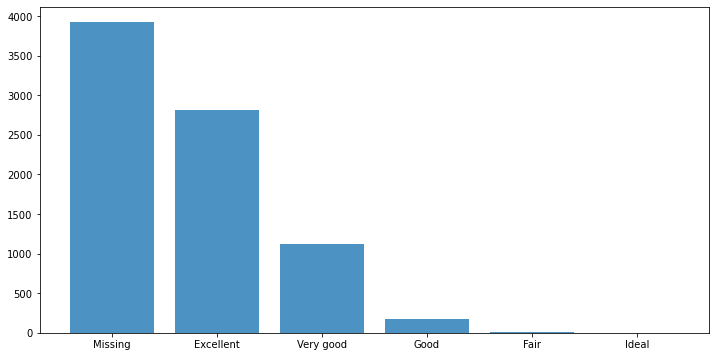

In [419]:
df_group = df.groupby('Cut').agg({'id': 'count'})
df_group.columns = ['count']
df_group = df_group.sort_values(by=['count'], ascending=False)
plt.figure(figsize=(12,6))
plt.bar(df_group.index, df_group['count'], alpha=0.8)

Here we can see that the Cut for many diamonds are missing.

Then we check the statistics of each different category.

In [420]:
df_group = df.groupby('Cut').agg({
    'id': 'count',
    'Profit': ['max', 'min', 'mean', 'std'],
    'Retail': ['max', 'min', 'mean', 'std'],
    'Price': ['max', 'min', 'mean', 'std']
})
df_group.columns = ['count', 'MaxProfit', 'MinProfit', 'AvgProfit', 'StdProfit', 'MaxRetail', 'MinRetail', 'AvgRetail', 'StdRetail', 'MaxPrice', 'MinPrice', 'AvgPrice', 'StdPrice']
df_group

,count,MaxProfit,MinProfit,AvgProfit,StdProfit,MaxRetail,MinRetail,AvgRetail,StdRetail,MaxPrice,MinPrice,AvgPrice,StdPrice
Cut,,,,,,,,,,,,,
Excellent,2811,467855,-137830,9087.207400,21140.240906,1104805,155,30849.548203,59092.948344,830540,635,21762.340804,40297.192686
Fair,15,176930,-2135,25048.333333,48573.383903,540850,455,76339.333333,147663.128690,363920,405,51291.000000,99122.175463
Good,178,95320,-18155,3164.044944,8269.148430,272340,420,10583.876404,22249.047656,177020,745,7419.831461,14567.887677
Ideal,1,48110,48110,48110.000000,NaN,151305,151305,151305.000000,NaN,103195,103195,103195.000000,NaN
Missing,3922,587405,-673680,5051.972208,21839.056902,1675190,45,16759.295003,49732.496487,1087785,395,11707.322794,35096.723157
Very good,1123,162865,-18690,4706.883348,10120.083822,465330,150,15498.325913,29191.151703,302465,635,10791.442565,19548.529388


From the results, we can see that generally the better Cut value, the higher profit.

The 'ideal' Cut diamond only has one sample, which means it is extremely scarce in the market.

The standard deviation of profit for 'Missing' Cut diamonds is over 4 times the average profit, suggesting that the profit fluctuates drastically within this caregory. Therefore, just adding a 'Missing' tag may not be efficient enough. (Although there aren't further supports for other options.)

The high standard deviation means that Cut is also not decisive of diamonds' profit.

In [421]:
index = df_new[df_new['Cut'] == ' '].index
for i in index:
    df_new['Cut'].iloc[i] = 'Missing'
df_new_group = df_new.groupby('Cut').agg({
    'id': 'count',
})
df_new_group.columns = ['count']
df_new_group

c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,count
Cut,
Excellent,953
Fair,4
Good,81
Ideal,1
Missing,1253
Very good,391


#### Measurements

First we check whether there are missing values (0 or invalid data) in the datasets.

In [422]:
df['Measurements_List'] = df['Measurements'].apply(lambda x: x.split('x'))
df['Measurements_Number'] = df['Measurements_List'].apply(lambda x: len(x))
index = df[df['Measurements_Number'] != 3].index
print(f'There are {len(index)} invalid Measurements in the training dataset.')
if len(index) > 0:
    print(df.loc[index])

There are 0 invalid Measurements in the training dataset.


In [423]:
df_new['Measurements_List'] = df_new['Measurements'].apply(lambda x: x.split('x'))
df_new['Measurements_Number'] = df_new['Measurements_List'].apply(lambda x: len(x))
index = df_new[df_new['Measurements_Number'] != 3].index
print(f'There are {len(index)} invalid Measurements in the testing dataset.')
if len(index) > 0:
    for i in index:
        print(df_new.loc[i])

There are 1 invalid Measurements in the testing dataset.
id                                    8877
Carats                                1.03
Cert                                  AGSL
Clarity                                SI1
Color                                    I
Cut                                Missing
Depth                                 62.7
Known_Conflict_Diamond               False
Measurements                6.42*6.47*4.04
Polish                           Excellent
Regions                           DR Congo
Shape                                Round
Symmetry                         Excellent
Table                                 57.0
Vendor                                   2
Measurements_List         [6.42*6.47*4.04]
Measurements_Number                      1
Name: 826, dtype: object


Notice that in the testing dataset, there is one sample with invalid Measurements format. We need to transfer it.

In [424]:
index = df_new[df_new['Measurements_Number'] != 3].index
for i in index:
    df_new['Measurements_List'].loc[i] = df_new['Measurements'].loc[i].split('*')
    df_new.loc[i]

c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [425]:
df['Long'] = df['Measurements_List'].apply(lambda x: float(x[0]))
df['Wide'] = df['Measurements_List'].apply(lambda x: float(x[1]))
df['Deep'] = df['Measurements_List'].apply(lambda x: float(x[2]))
df_new['Long'] = df_new['Measurements_List'].apply(lambda x: float(x[0]))
df_new['Wide'] = df_new['Measurements_List'].apply(lambda x: float(x[1]))
df_new['Deep'] = df_new['Measurements_List'].apply(lambda x: float(x[2]))

Then we will check each feature (long/wide/deep) separately.

##### Long

First we check whether there are missing values (0) in the datasets.

In [426]:
name = 'Long'
number = len(df[name].loc[df[name].isna()])
number += len(df[(df[name]) <= 0])
print(f'There are {number} rows with missing values of column {name}. (Training Dataset)')
number = len(df_new[name].loc[df_new[name].isna()])
number += len(df_new[(df_new[name]) <= 0])
print(f'There are {number} rows with missing values of column {name}. (Testing Dataset)')

There are 0 rows with missing values of column Long. (Training Dataset)
There are 0 rows with missing values of column Long. (Testing Dataset)


Then we check the distribution of Long for both the training and testing datasets.

([<matplotlib.axis.XTick at 0x1e79ae9ca60>,
 [Text(0, 0, 'Training'), Text(1, 0, 'Testing')])

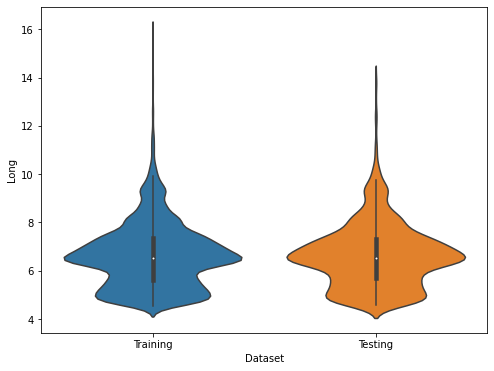

In [427]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=[df['Long'], df_new['Long']])
plt.xlabel('Dataset')
plt.ylabel('Long')
plt.xticks(ticks=[0, 1], labels=['Training', 'Testing'])

From the above violin plots, we can see that the distribution of Long is similar for the training and testing datasets.

Most Long values range from 6-8, and the majority of Long values range from 4-10.

There are few outliers with bigger Long values than others.

Then we analyze the correlation of Long between retail/price/profit.

In [428]:
for item in ['Retail', 'Price', 'Profit']:
    corr = np.corrcoef(df['Long'], df[item])[0, 1]
    x = '%.4f' % corr
    print(f'The correlation between Long and {item} is {x}.')

The correlation between Long and Retail is 0.6068.
The correlation between Long and Price is 0.6255.
The correlation between Long and Profit is 0.4396.


We can see that the Long feature is highly and positively correlated to the profit.

##### Wide

First we check whether there are missing values (0) in the datasets.

In [429]:
name = 'Wide'
number = len(df[name].loc[df[name].isna()])
number += len(df[(df[name]) <= 0])
print(f'There are {number} rows with missing values of column {name}. (Training Dataset)')
number = len(df_new[name].loc[df_new[name].isna()])
number += len(df_new[(df_new[name]) <= 0])
print(f'There are {number} rows with missing values of column {name}. (Testing Dataset)')

There are 0 rows with missing values of column Wide. (Training Dataset)
There are 0 rows with missing values of column Wide. (Testing Dataset)


Then we check the distribution of Wide for both the training and testing datasets.

([<matplotlib.axis.XTick at 0x1e7aa9510a0>,
 [Text(0, 0, 'Training'), Text(1, 0, 'Testing')])

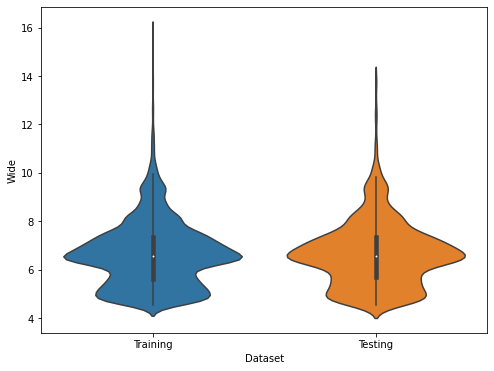

In [430]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=[df['Wide'], df_new['Wide']])
plt.xlabel('Dataset')
plt.ylabel('Wide')
plt.xticks(ticks=[0, 1], labels=['Training', 'Testing'])

From the above violin plots, we can see that the distribution of Wide is similar for the training and testing datasets.

Most Wide values range from 6-8, and the majority of Wide values range from 4-10.

There are few outliers with bigger Wide values than others.

Then we analyze the correlation of Wide between retail/price/profit.

In [431]:
for item in ['Retail', 'Price', 'Profit']:
    corr = np.corrcoef(df['Wide'], df[item])[0, 1]
    x = '%.4f' % corr
    print(f'The correlation between Wide and {item} is {x}.')

The correlation between Wide and Retail is 0.6063.
The correlation between Wide and Price is 0.6248.
The correlation between Wide and Profit is 0.4394.


We can see that the Wide feature is highly and positively correlated to the profit.

Actually, the result of Long and Wide are so similar that we can imagine a high correlation between them.

In [432]:
corr = np.corrcoef(df['Long'], df['Wide'])[0, 1]
x = '%.4f' % corr
print(f'The correlation between Long and Wide is {x}.')

The correlation between Long and Wide is 0.9993.


Here we can see that Long and Wide are actually identical. This may be intrepred by the fact that most diamonds have a rotational symmetric shape.

##### Deep

First we check whether there are missing values (0) in the datasets.

In [433]:
name = 'Deep'
number = len(df[name].loc[df[name].isna()])
number += len(df[(df[name]) <= 0])
print(f'There are {number} rows with missing values of column {name}. (Training Dataset)')
number = len(df_new[name].loc[df_new[name].isna()])
number += len(df_new[(df_new[name]) <= 0])
print(f'There are {number} rows with missing values of column {name}. (Testing Dataset)')

There are 0 rows with missing values of column Deep. (Training Dataset)
There are 0 rows with missing values of column Deep. (Testing Dataset)


Then we check the distribution of Deep for both the training and testing datasets.

([<matplotlib.axis.XTick at 0x1e7ab98d1f0>,
 [Text(0, 0, 'Training'), Text(1, 0, 'Testing')])

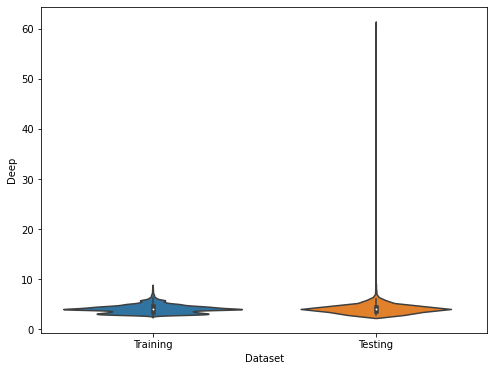

In [434]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=[df['Deep'], df_new['Deep']])
plt.xlabel('Dataset')
plt.ylabel('Deep')
plt.xticks(ticks=[0, 1], labels=['Training', 'Testing'])

We notice here are some extreme values for the testing datsets.

In [435]:
deep = df_new['Deep'].to_list()
deep.sort()
deep.reverse()
deep[:10]

[60.9, 8.81, 8.58, 8.58, 8.58, 8.28, 7.8, 7.62, 7.62, 7.55]

In [436]:
df_new[df_new['Deep'] == 60.9]

,id,Carats,Cert,Clarity,Color,Cut,Depth,Known_Conflict_Diamond,Measurements,Polish,Regions,Shape,Symmetry,Table,Vendor,Measurements_List,Measurements_Number,Long,Wide,Deep
2173,10224,2.01,AGSL,SI2,H,Excellent,60.9,False,8.2x8.14x60.9,Excellent,Russia,Round,Excellent,59.0,2,"[8.2, 8.14, 60.9]",3,8.2,8.14,60.9


Here we can find an outlier with extreme large Deep value. We may drop this sample temporarily for better visualization. (Or it maybe 6.09 instead, since it is so large.)

([<matplotlib.axis.XTick at 0x1e7ab964190>,
 [Text(0, 0, 'Training'), Text(1, 0, 'Testing')])

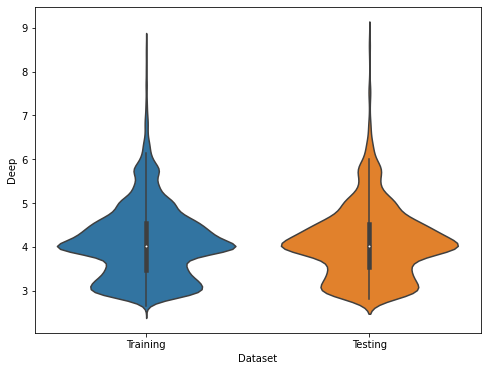

In [437]:
temp_df = df_new[df_new['Deep'] < 10]
plt.figure(figsize=(8, 6))
sns.violinplot(data=[df['Deep'], temp_df['Deep']])
plt.xlabel('Dataset')
plt.ylabel('Deep')
plt.xticks(ticks=[0, 1], labels=['Training', 'Testing'])

From the above violin plots, we can see that the distribution of Deep is similar for the training and testing datasets.

Most Wide values range from 4-5, and the majority of Deep values range from 3-7.

There are few outliers with bigger Deep values than others.

Then we analyze the correlation of Deep between retail/price/profit.

In [438]:
for item in ['Retail', 'Price', 'Profit']:
    corr = np.corrcoef(df['Deep'], df[item])[0, 1]
    x = '%.4f' % corr
    print(f'The correlation between Deep and {item} is {x}.')

The correlation between Deep and Retail is 0.6009.
The correlation between Deep and Price is 0.6195.
The correlation between Deep and Profit is 0.4352.


We can see that the Deep feature is highly and positively correlated to the profit.

#### Polish

First we check all the categories of Polish. Here we also need to add a 'Missing' tag.

c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


There are 4 categories of Polish.
All the categories are ['Good', 'Missing', 'Very good', 'Excellent']


<BarContainer object of 4 artists>

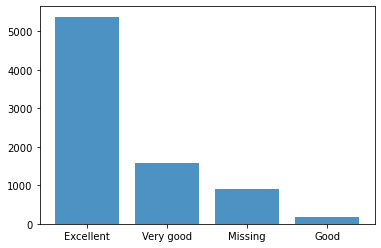

In [439]:
index = df[df['Polish'] == ' '].index
for i in index:
    df['Polish'].iloc[i] = 'Missing'
polish = list(set(df['Polish'].to_list()))
print(f'There are {len(polish)} categories of Polish.')
print(f'All the categories are {polish}')
df_group = df.groupby('Polish').agg({'id': 'count'})
df_group.columns = ['count']
df_group = df_group.sort_values(by=['count'], ascending=False)
plt.bar(df_group.index, df_group['count'], alpha=0.8)

Here we can see only a few diamonds have missing Polish.

Then we check the statistics of each different category.

In [440]:
df_group = df.groupby('Polish').agg({
    'id': 'count',
    'Profit': ['max', 'min', 'mean', 'std'],
    'Retail': ['max', 'min', 'mean', 'std'],
    'Price': ['max', 'min', 'mean', 'std']
})
df_group.columns = ['count', 'MaxProfit', 'MinProfit', 'AvgProfit', 'StdProfit', 'MaxRetail', 'MinRetail', 'AvgRetail', 'StdRetail', 'MaxPrice', 'MinPrice', 'AvgPrice', 'StdPrice']
df_group

,count,MaxProfit,MinProfit,AvgProfit,StdProfit,MaxRetail,MinRetail,AvgRetail,StdRetail,MaxPrice,MinPrice,AvgPrice,StdPrice
Polish,,,,,,,,,,,,,
Excellent,5383,587405,-673680,7713.704254,24022.793440,1675190,45,26070.014862,59939.927089,1087785,395,18356.310607,41560.222089
Good,179,66200,-26825,3155.083799,7080.018538,199065,330,10584.301676,19496.256200,132865,635,7429.217877,13524.286818
Missing,899,184405,-17275,4341.562848,9301.837030,531035,120,13785.289210,26715.760089,346630,455,9443.726363,17873.694595
Very good,1589,117155,-20990,3549.493392,8130.920715,334725,75,11586.233480,24178.624477,238365,405,8036.740088,16536.704737


Here we can see that diamonds with better Polish tend to have higher profit.

Most diamonds are with 'Excellent' Polish, which means that Polish may be a necessary condition for high profit.

But the standard deviation of profit is so high (more than 2 times the average profit), it is definitely not so decisive.

In [441]:
index = df_new[df_new['Polish'] == ' '].index
for i in index:
    df_new['Polish'].iloc[i] = 'Missing'
df_new_group = df_new.groupby('Polish').agg({
    'id': 'count',
})
df_new_group.columns = ['count']
df_new_group

c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,count
Polish,
Excellent,1781
Fair,2
Good,70
Missing,291
Very good,539


Here in the testing dataset, there is a new value 'Fair'.

Since there is no such value in the training dataset, we may as well replace it with 'Good', because they are similar in meanings.

In [442]:
index = df_new[df_new['Polish'] == 'Fair'].index
for i in index:
    df_new['Polish'].iloc[i] = 'Good'
df_new_group = df_new.groupby('Polish').agg({
    'id': 'count',
})
df_new_group.columns = ['count']
df_new_group

c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,count
Polish,
Excellent,1781
Good,72
Missing,291
Very good,539


#### Regions

First we check all the categories of Regions.

There are 9 categories of Regions.
All the categories are ['Australia', 'Canada', 'Other/Unknown', 'Zimbabwe', 'Russia', 'Botswana', 'Angola', 'South Africa', 'DR Congo']


<BarContainer object of 9 artists>

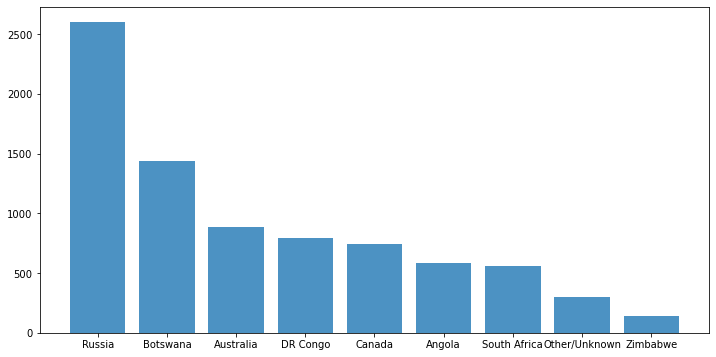

In [443]:
regions = list(set(df['Regions'].to_list()))
print(f'There are {len(regions)} categories of Regions.')
print(f'All the categories are {regions}')
df_group = df.groupby('Regions').agg({'id': 'count'})
df_group.columns = ['count']
df_group = df_group.sort_values(by=['count'], ascending=False)
plt.figure(figsize=(12,6))
plt.bar(df_group.index, df_group['count'], alpha=0.8)

Then we check the statistics of each different category.

In [444]:
df_group = df.groupby('Regions').agg({
    'id': 'count',
    'Profit': ['max', 'min', 'mean', 'std'],
    'Retail': ['max', 'min', 'mean', 'std'],
    'Price': ['max', 'min', 'mean', 'std']
})
df_group.columns = ['count', 'MaxProfit', 'MinProfit', 'AvgProfit', 'StdProfit', 'MaxRetail', 'MinRetail', 'AvgRetail', 'StdRetail', 'MaxPrice', 'MinPrice', 'AvgPrice', 'StdPrice']
df_group

,count,MaxProfit,MinProfit,AvgProfit,StdProfit,MaxRetail,MinRetail,AvgRetail,StdRetail,MaxPrice,MinPrice,AvgPrice,StdPrice
Regions,,,,,,,,,,,,,
Angola,586,206305,-97425,4065.085324,17673.694669,574100,45,19160.767918,43443.083479,367795,500,15095.682594,29708.249672
Australia,887,188965,-16935,6949.374295,12819.940583,538905,625,20339.808343,36302.506611,349940,545,13390.434047,24025.012309
Botswana,1438,286990,-19330,6324.700974,17079.176414,1104805,455,21210.462448,55855.319795,830540,405,14885.761474,39388.375177
Canada,745,587405,-3220,8835.067114,32180.603671,1675190,645,25142.114094,84461.807045,1087785,570,16307.046980,53068.485082
DR Congo,796,322685,-673680,1723.831658,31824.097506,745880,90,17887.305276,42411.601857,783180,595,16163.473618,41397.599568
Other/Unknown,303,403145,-645,8829.620462,26325.743735,875780,850,25473.234323,61914.839669,472635,430,16643.613861,36219.073097
Russia,2599,230500,-19780,7712.568295,15449.105439,658580,380,22927.751058,45137.289740,428080,395,15215.182763,30019.263553
South Africa,556,255940,-5435,5760.386691,13304.369325,842730,575,20079.640288,47568.543384,586790,560,14319.253597,35753.270447
Zimbabwe,140,89460,-145630,801.964286,16639.419756,210520,210,13011.785714,22703.461198,178980,600,12209.821429,20215.606545


Here we can see that there exists some regional difference in terms of diamond profit.

More developed country may have higher profits, maybe owing to the diamond processing techniques/market & customers and so on.

Other/Unknown Regions have a really high profit, which may be a little surprising.

The standard deviation is also high here, signifying that Regions is not a decisive factor.

In [445]:
df_new_group = df_new.groupby('Regions').agg({
    'id': 'count',
})
df_new_group.columns = ['count']
df_new_group

,count
Regions,
Angola,182
Australia,297
Botswana,445
Canada,261
DR Congo,283
Other/Unknown,91
Russia,896
South Africa,174
Zimbabwe,54


#### Shape

First we check all the categories of Shape.

In [446]:
shape = list(set(df['Shape'].to_list()))
print(f'There are {len(shape)} categories of Shape.')
print(f'All the categories are {shape}')

There are 13 categories of Shape.
All the categories are ['ROUND', 'Radiant', 'Cushion', 'Pear', 'Asscher', 'Princess', 'Marquise', 'Oval', 'Uncut', 'Round', 'Emerald', 'Oval ', 'Marquis']


Here the Shape 'Oval' is repeated with a space at the end.

In [447]:
index = df[df['Shape'] == 'Oval '].index
for i in index:
    df['Shape'].iloc[i] = 'Oval'
shape = list(set(df['Shape'].to_list()))
print(f'There are {len(shape)} categories of Shape.')
print(f'All the categories are {shape}')

c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


There are 12 categories of Shape.
All the categories are ['ROUND', 'Radiant', 'Cushion', 'Pear', 'Asscher', 'Princess', 'Marquise', 'Oval', 'Uncut', 'Round', 'Emerald', 'Marquis']


<BarContainer object of 12 artists>

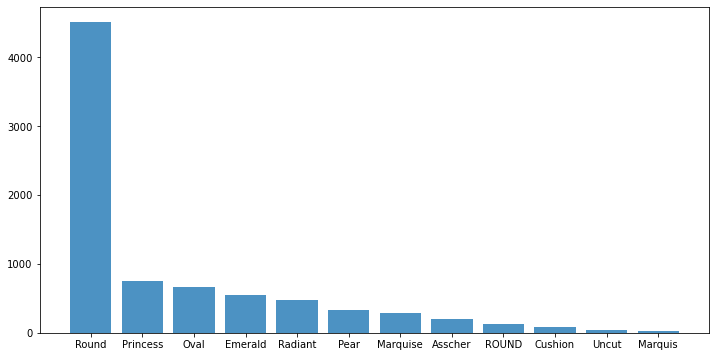

In [448]:
df_group = df.groupby('Shape').agg({'id': 'count'})
df_group.columns = ['count']
df_group = df_group.sort_values(by=['count'], ascending=False)
plt.figure(figsize=(12,6))
plt.bar(df_group.index, df_group['count'], alpha=0.8)

Then we check the statistics of each different category.

In [449]:
df_group = df.groupby('Shape').agg({
    'id': 'count',
    'Profit': ['max', 'min', 'mean', 'std'],
    'Retail': ['max', 'min', 'mean', 'std'],
    'Price': ['max', 'min', 'mean', 'std']
})
df_group.columns = ['count', 'MaxProfit', 'MinProfit', 'AvgProfit', 'StdProfit', 'MaxRetail', 'MinRetail', 'AvgRetail', 'StdRetail', 'MaxPrice', 'MinPrice', 'AvgPrice', 'StdPrice']
df_group

,count,MaxProfit,MinProfit,AvgProfit,StdProfit,MaxRetail,MinRetail,AvgRetail,StdRetail,MaxPrice,MinPrice,AvgPrice,StdPrice
Shape,,,,,,,,,,,,,
Asscher,194,69180,-673680,2476.572165,49996.021497,448270,290,22019.484536,43033.698962,783180,655,19542.912371,65057.617523
Cushion,87,35815,-145630,2053.448276,18160.474640,102325,440,15322.471264,16773.483969,178980,715,13269.022989,21912.679998
Emerald,554,366760,-51325,6841.254513,21285.711514,1047880,215,22324.945848,60057.577473,681120,615,15483.691336,39323.610681
Marquis,28,74000,-16380,10286.964286,16320.432680,254160,1710,26768.750000,48830.853779,180160,890,16481.785714,33840.852482
Marquise,285,178805,-76020,7471.052632,19807.942903,540850,270,23681.947368,54388.479856,363920,515,16210.894737,36225.980874
Oval,665,467855,-57555,8012.609023,25442.230327,889985,130,23422.616541,58045.612784,423195,595,15410.007519,34049.320515
Pear,336,230500,-28775,7649.181548,18826.561353,658580,360,25010.357143,53160.592354,428080,615,17361.175595,35102.811920
Princess,754,162865,-39960,5773.242706,12307.576074,465330,135,19777.294430,35286.883715,302465,430,14004.051724,24256.662846
ROUND,123,117155,-137830,4422.926829,18634.277334,334725,1050,19706.422764,35205.460628,217570,730,15283.495935,27296.722683


Here we can see most diamonds are round shaped, having a medium profit.

The average profit may vary drastically among different Shapes.

Uncut shaped diamonds have negative average profit, which is unique.

In [450]:
df_new_group = df_new.groupby('Shape').agg({
    'id': 'count',
})
df_new_group.columns = ['count']
df_new_group

,count
Shape,
Asscher,76
Cushion,26
Emerald,196
Marquis,9
Marquise,97
Oval,183
Oval,50
Pear,92
Princess,252


#### Symmetry

First we check all the categories of Symmetry.

In [451]:
symmetry = list(set(df['Symmetry'].to_list()))
print(f'There are {len(symmetry)} categories of Symmetry.')
print(f'All the categories are {symmetry}')

There are 7 categories of Symmetry.
All the categories are ['Very good', 'Faint', 'Fair', 'Good', 'Execllent', ' ', 'Excellent']


Here we should replace the category ' ' with 'Missing'.

There is also a typo in 'Execllent'.

In [452]:
index = df[df['Symmetry'] == ' '].index
for i in index:
    df['Symmetry'].iloc[i] = 'Missing'
index = df[df['Symmetry'] == 'Execllent'].index
for i in index:
    df['Symmetry'].iloc[i] = 'Excellent'
symmetry = list(set(df['Symmetry'].to_list()))
print(f'There are {len(symmetry)} categories of Symmetry.')
print(f'All the categories are {symmetry}')

c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


There are 6 categories of Symmetry.
All the categories are ['Missing', 'Very good', 'Faint', 'Fair', 'Good', 'Excellent']


<BarContainer object of 6 artists>

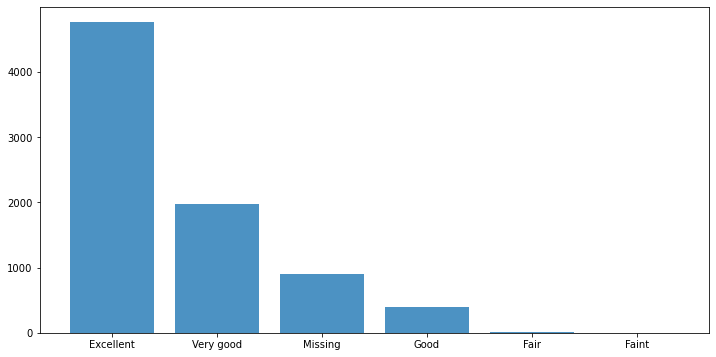

In [453]:
df_group = df.groupby('Symmetry').agg({'id': 'count'})
df_group.columns = ['count']
df_group = df_group.sort_values(by=['count'], ascending=False)
plt.figure(figsize=(12,6))
plt.bar(df_group.index, df_group['count'], alpha=0.8)

Here we can see only a few diamonds have missing Symmetry.

Then we check the statistics of each different category.

In [454]:
df_group = df.groupby('Symmetry').agg({
    'id': 'count',
    'Profit': ['max', 'min', 'mean', 'std'],
    'Retail': ['max', 'min', 'mean', 'std'],
    'Price': ['max', 'min', 'mean', 'std']
})
df_group.columns = ['count', 'MaxProfit', 'MinProfit', 'AvgProfit', 'StdProfit', 'MaxRetail', 'MinRetail', 'AvgRetail', 'StdRetail', 'MaxPrice', 'MinPrice', 'AvgPrice', 'StdPrice']
df_group

,count,MaxProfit,MinProfit,AvgProfit,StdProfit,MaxRetail,MinRetail,AvgRetail,StdRetail,MaxPrice,MinPrice,AvgPrice,StdPrice
Symmetry,,,,,,,,,,,,,
Excellent,4760,587405,-673680,8118.991597,25015.283971,1675190,45,27562.922269,61963.077217,1087785,500,19443.930672,43072.658066
Faint,3,1225,310,720.000000,464.838682,3100,1110,1941.666667,1034.436239,1875,800,1221.666667,573.723220
Fair,16,19330,-6615,2894.062500,5158.648472,49300,660,8768.437500,11704.932966,29970,405,5874.375000,7066.859952
Good,392,134580,-26825,3688.150510,10257.303933,398555,225,12217.206633,29766.288308,263975,430,8529.056122,20150.558023
Missing,899,184405,-17275,4341.562848,9301.837030,531035,120,13785.289210,26715.760089,346630,455,9443.726363,17873.694595
Very good,1980,206305,-25350,3831.896465,9902.678609,574100,95,12376.378788,28652.929904,367795,395,8544.482323,19170.927730


Here we can see most diamonds have high level of Symmetry (Excellent/Very good), leading to rather higher profit.

Few diamonds with low Symmetry tend to have low profit.

Diamonds with missing Symmetry tend to have rather high profit.

In [455]:
index = df_new[df_new['Symmetry'] == ' '].index
for i in index:
    df_new['Symmetry'].iloc[i] = 'Missing'
df_new_group = df_new.groupby('Symmetry').agg({
    'id': 'count',
})
df_new_group.columns = ['count']
df_new_group

c:\Users\fuym20\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,count
Symmetry,
Excellent,1542
Faint,1
Fair,6
Good,166
Missing,291
Very good,677


#### Vendor

First we check all the categories of Vendor.

There are 4 categories of Vendor.
All the categories are ['4', '1', '2', '3']


<BarContainer object of 4 artists>

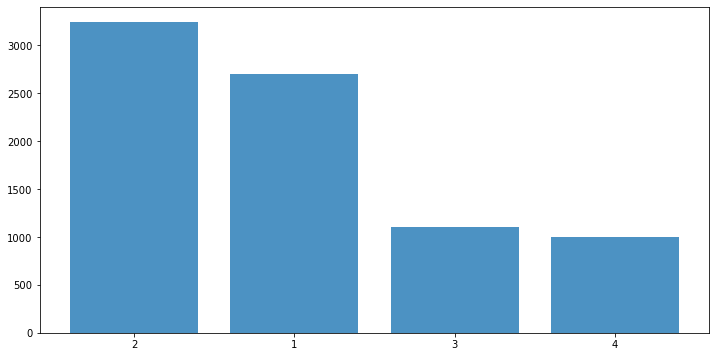

In [456]:
df['Vendor'] = df['Vendor'].apply(lambda x: str(x))
vendor = list(set(df['Vendor'].to_list()))
print(f'There are {len(vendor)} categories of Vendor.')
print(f'All the categories are {vendor}')
df_group = df.groupby('Vendor').agg({'id': 'count'})
df_group.columns = ['count']
df_group = df_group.sort_values(by=['count'], ascending=False)
df_group.index = [str(i) for i in df_group.index]
plt.figure(figsize=(12,6))
plt.bar(df_group.index, df_group['count'], alpha=0.8)

Then we check the statistics of each different category.

In [457]:
df_group = df.groupby('Vendor').agg({
    'id': 'count',
    'Profit': ['max', 'min', 'mean', 'std'],
    'Retail': ['max', 'min', 'mean', 'std'],
    'Price': ['max', 'min', 'mean', 'std']
})
df_group.columns = ['count', 'MaxProfit', 'MinProfit', 'AvgProfit', 'StdProfit', 'MaxRetail', 'MinRetail', 'AvgRetail', 'StdRetail', 'MaxPrice', 'MinPrice', 'AvgPrice', 'StdPrice']
df_group

,count,MaxProfit,MinProfit,AvgProfit,StdProfit,MaxRetail,MinRetail,AvgRetail,StdRetail,MaxPrice,MinPrice,AvgPrice,StdPrice
Vendor,,,,,,,,,,,,,
1,2702,7695,-5800,1240.529238,1335.389502,15805,45,3604.009993,2792.686575,9480,395,2363.480755,1694.092359
2,3241,587405,-673680,12001.488738,30894.499324,1675190,370,39124.959889,76957.682430,1087785,600,27123.471151,53241.546237
3,1106,18600,-23545,5014.303797,4409.811158,46310,340,15292.400542,8123.491228,28360,2560,10278.096745,5173.388049
4,1001,22935,-39960,3832.452547,4929.034257,54730,720,19557.997003,10743.500722,44890,3775,15725.544456,8416.191382


Here we can see that Vendor 2 has the highest average profit as well as the standard deviation, which means he/she targets as high-price deals with high profit and high risk, while the deals quanitity are also very large.

The profit situation is rather stable for the other three vendors, especially for Vendor 3.

Vendor 1 has the lowest average profit, which means he/she targets at small deals with big volume.

In [458]:
df_new_group = df_new.groupby('Vendor').agg({
    'id': 'count',
})
df_new_group.columns = ['count']
df_new_group

,count
Vendor,
1,911
2,1072
3,368
4,332


### Process Categorical Variables

Here we use the get_dummies() function to generate dummy variables for the categorical variables.

In [459]:
df_temp = df.copy()
try:
    del df_temp['Measurements_List']
except:
    pass
try:
    del df_temp['Measurements']
except:
    pass
try:
    del df_temp['Measurements_Number']
except:
    pass
df_dummies = pd.get_dummies(df_temp)
print('All the variables are', end=': ')
for column in df_dummies.columns:
    print(column, end=', ')
print(f'\nThere are {len(df_dummies.columns) - 1} variables altogether. (Without id)')

All the variables are: id, Carats, Depth, Known_Conflict_Diamond, Table, Price, Retail, LogPrice, LogRetail, Profit, Long, Wide, Deep, Cert_AGSL, Cert_GemEx, Cert_Unknown, Clarity_FL, Clarity_I1, Clarity_I2, Clarity_I3, Clarity_IF, Clarity_N, Clarity_None, Clarity_SI1, Clarity_SI2, Clarity_VS1, Clarity_VS2, Clarity_VVS1, Clarity_VVS2, Color_D, Color_E, Color_F, Color_Fdpink, Color_Fdy, Color_Ffcdbrown, Color_Ffcg, Color_Ffcly, Color_Ffcy, Color_Ffg, Color_Fiy, Color_Fiyellow, Color_Fly, Color_Flyellow, Color_Fvyellow, Color_Fyellow, Color_G, Color_Gy, Color_H, Color_I, Color_J, Color_K, Color_L, Color_Lb, Color_M, Color_N, Color_O-p, Color_P, Color_Q-r, Color_S, Color_U, Color_W, Cut_Excellent, Cut_Fair, Cut_Good, Cut_Ideal, Cut_Missing, Cut_Very good, Polish_Excellent, Polish_Good, Polish_Missing, Polish_Very good, Regions_Angola, Regions_Australia, Regions_Botswana, Regions_Canada, Regions_DR Congo, Regions_Other/Unknown, Regions_Russia, Regions_South Africa, Regions_Zimbabwe, Shape_

In [460]:
df_temp = df_new.copy()
try:
    del df_temp['Measurements_List']
except:
    pass
try:
    del df_temp['Measurements']
except:
    pass
try:
    del df_temp['Measurements_Number']
except:
    pass
df_new_dummies = pd.get_dummies(df_temp)
print('All the variables are', end=': ')
for column in df_new_dummies.columns:
    print(column, end=', ')
print(f'\nThere are {len(df_new_dummies.columns) - 1} variables altogether. (Without id)')

All the variables are: id, Carats, Depth, Known_Conflict_Diamond, Table, Vendor, Long, Wide, Deep, Cert_AGSL, Cert_GemEx, Cert_Unknown, Clarity_I1, Clarity_I2, Clarity_I3, Clarity_IF, Clarity_SI1, Clarity_SI2, Clarity_VS1, Clarity_VS2, Clarity_VVS1, Clarity_VVS2, Color_D, Color_E, Color_F, Color_Ffancy darkbrown, Color_Flby, Color_G, Color_H, Color_I, Color_J, Color_K, Color_L, Color_M, Color_N, Color_S-t, Color_T, Cut_Excellent, Cut_Fair, Cut_Good, Cut_Ideal, Cut_Missing, Cut_Very good, Polish_Excellent, Polish_Good, Polish_Missing, Polish_Very good, Regions_Angola, Regions_Australia, Regions_Botswana, Regions_Canada, Regions_DR Congo, Regions_Other/Unknown, Regions_Russia, Regions_South Africa, Regions_Zimbabwe, Shape_Asscher, Shape_Cushion, Shape_Emerald, Shape_Marquis, Shape_Marquise, Shape_Oval, Shape_Oval , Shape_Pear, Shape_Princess, Shape_ROUND, Shape_Radiant, Shape_Round, Shape_Uncut, Symmetry_Excellent, Symmetry_Faint, Symmetry_Fair, Symmetry_Good, Symmetry_Missing, Symmetry_

Notice that the training and testing datasets have different numbers of variables, even without considering all the monetary ones.

So we need to adjust the testing dataset to the training dataset.

In [461]:
df_new_dummies = df_new_dummies.reindex(columns=df_dummies.columns, fill_value=0)
print(f'Shape of the training dataset: {df_dummies.shape}')
print(f'Shape of the testing dataset: {df_new_dummies.shape}')

Shape of the training dataset: (8050, 102)
Shape of the testing dataset: (2683, 102)


### Standardization

First we renew the continuous variables here.

In [462]:
continuous_vars = df.select_dtypes(include=[np.number]).columns.to_list()
exclude = ['id', 'Vendor', 'Price', 'Retail', 'LogPrice', 'LogRetail', 'Profit']
for var in exclude:
    try:
        continuous_vars.remove(var)
    except:
        pass
try:
    continuous_vars.remove('Measurements_Number')
except:
    pass
print(f'The continuous variables are {continuous_vars}.')
print(f'The number of continuous variables is {len(continuous_vars)}.')

The continuous variables are ['Carats', 'Depth', 'Table', 'Long', 'Wide', 'Deep'].
The number of continuous variables is 6.


Then we use the scaler to standardize data.

In [463]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[continuous_vars])
df_scaled = pd.DataFrame(df_scaled, columns=continuous_vars, index=df.index)
df_scaled.head(5)

,Carats,Depth,Table,Long,Wide,Deep
0,-0.956724,2.803381,-1.188409,-1.479575,-1.497445,-1.305272
1,-0.945545,-0.066969,-0.129014,-1.331469,-1.372832,-1.365727
2,-0.967903,1.717302,-0.599856,-1.472170,-1.490115,-1.377818
3,-0.956724,0.708801,-0.011303,-1.435143,-1.446134,-1.402000
4,-0.967903,0.941532,-0.011303,-1.435143,-1.453464,-1.389909


Here we use the training dataset to fit the scaler, and to standardize the testing dataset.

In [464]:
df_new_scaled = scaler.transform(df_new[continuous_vars])
df_new_scaled = pd.DataFrame(df_new_scaled, columns=continuous_vars, index=df_new.index)
df_new_scaled.head(5)

,Carats,Depth,Table,Long,Wide,Deep
0,-0.945545,0.708801,-0.599856,-1.361090,-1.380162,-1.329454
1,-0.967903,1.562148,0.577250,-1.486980,-1.504775,-1.402000
2,-0.956724,0.320916,-0.011303,-1.398117,-1.409483,-1.402000
3,-0.967903,1.872456,-0.011303,-1.494385,-1.519436,-1.389909
4,-0.967903,1.950033,0.459539,-1.464764,-1.497445,-1.353636


Finally we need to merge the standardized continous data with the categorical variables together.

In [465]:
df_final = df_dummies.copy()
for var in continuous_vars:
    df_final[var] = df_scaled[var]
df_final.head(5)

,id,Carats,Depth,Known_Conflict_Diamond,Table,Price,Retail,LogPrice,LogRetail,Profit,...,Symmetry_Excellent,Symmetry_Faint,Symmetry_Fair,Symmetry_Good,Symmetry_Missing,Symmetry_Very good,Vendor_1,Vendor_2,Vendor_3,Vendor_4
0,1,-0.956724,2.803381,False,-1.188409,430,850,6.063785,6.745236,420,...,0,0,0,1,0,0,1,0,0,0
1,2,-0.945545,-0.066969,False,-0.129014,560,920,6.327937,6.824374,360,...,0,0,0,0,0,1,1,0,0,0
2,3,-0.967903,1.717302,False,-0.599856,560,575,6.327937,6.354370,15,...,1,0,0,0,0,0,1,0,0,0
3,4,-0.956724,0.708801,False,-0.011303,560,825,6.327937,6.715383,265,...,0,0,0,0,0,1,1,0,0,0
4,5,-0.967903,0.941532,False,-0.011303,580,890,6.363028,6.791221,310,...,0,0,0,0,0,1,1,0,0,0


In [466]:
df_new_final = df_new_dummies.copy()
for var in continuous_vars:
    df_new_final[var] = df_new_scaled[var]
df_new_final.head(5)

,id,Carats,Depth,Known_Conflict_Diamond,Table,Price,Retail,LogPrice,LogRetail,Profit,...,Symmetry_Excellent,Symmetry_Faint,Symmetry_Fair,Symmetry_Good,Symmetry_Missing,Symmetry_Very good,Vendor_1,Vendor_2,Vendor_3,Vendor_4
0,8051,-0.945545,0.708801,False,-0.599856,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,8052,-0.967903,1.562148,False,0.577250,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,8053,-0.956724,0.320916,True,-0.011303,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,8054,-0.967903,1.872456,False,-0.011303,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,8055,-0.967903,1.950033,False,0.459539,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Multicolinearity Checking

In [467]:
# Calculate correlation matrix
correlation_matrix = df_final[continuous_vars].corr()

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = continuous_vars
vif_data["VIF"] = [variance_inflation_factor(df_final[continuous_vars].values, i) for i in range(len(continuous_vars))]

print("\nVariance Inflation Factors:")
display(vif_data)


Variance Inflation Factors:


,Variable,VIF
0,Carats,10.386401
1,Depth,3.290395
2,Table,1.274150
3,Long,824.804071
4,Wide,741.863687
5,Deep,213.962034


In [468]:
dict_removed_var = {}
def cal_VIF(df, exclude_vars=[]):
    numeric_df = df.select_dtypes(include=[np.float64])
    include_vars = [var for var in continuous_vars if var not in exclude_vars]
    vif_data = pd.DataFrame()
    vif_data["Variable"] = include_vars
    vif_data["VIF"] = [variance_inflation_factor(numeric_df[include_vars].values, i) for i in range(len(include_vars))]
    return vif_data

excluded_vars = []
iteration = 0
vif_data = cal_VIF(df_final, excluded_vars)

while vif_data['VIF'].max() > 10:
    max_vif_var = vif_data.sort_values('VIF', ascending=False).iloc[0]['Variable']
    max_vif_value = vif_data.sort_values('VIF', ascending=False).iloc[0]['VIF']
    print(f"\nIteration {iteration}: Removed variable '{max_vif_var}' with VIF {max_vif_value}")
    excluded_vars.append(max_vif_var)
    vif_data = cal_VIF(df_final, excluded_vars)
    dict_removed_var[max_vif_var] = vif_data
    display(vif_data)
    iteration += 1


Iteration 0: Removed variable 'Long' with VIF 824.8040712471254


,Variable,VIF
0,Carats,9.982518
1,Depth,3.064859
2,Table,1.274106
3,Wide,205.486503
4,Deep,190.018022



Iteration 1: Removed variable 'Wide' with VIF 205.48650271204357


,Variable,VIF
0,Carats,9.443324
1,Depth,1.295332
2,Table,1.256349
3,Deep,9.336242


Then we should drop the excluded variables.

In [469]:
try:
    df_final = df_final.drop(columns=excluded_vars)
except:
    pass
try:
    df_new_final = df_new_final.drop(columns=excluded_vars)
except:
    pass
print(f'Shape of the training dataset: {df_final.shape}')
print(f'Shape of the testing dataset: {df_new_final.shape}')

Shape of the training dataset: (8050, 100)
Shape of the testing dataset: (2683, 100)


In [470]:
df_final.columns

Index(['id', 'Carats', 'Depth', 'Known_Conflict_Diamond', 'Table', 'Price', 'Retail', 'LogPrice', 'LogRetail', 'Profit', 'Deep', 'Cert_AGSL', 'Cert_GemEx', 'Cert_Unknown', 'Clarity_FL', 'Clarity_I1', 'Clarity_I2', 'Clarity_I3', 'Clarity_IF', 'Clarity_N', 'Clarity_None', 'Clarity_SI1', 'Clarity_SI2', 'Clarity_VS1', 'Clarity_VS2', 'Clarity_VVS1', 'Clarity_VVS2', 'Color_D', 'Color_E', 'Color_F', 'Color_Fdpink', 'Color_Fdy', 'Color_Ffcdbrown', 'Color_Ffcg', 'Color_Ffcly', 'Color_Ffcy', 'Color_Ffg', 'Color_Fiy', 'Color_Fiyellow', 'Color_Fly', 'Color_Flyellow', 'Color_Fvyellow', 'Color_Fyellow', 'Color_G', 'Color_Gy', 'Color_H', 'Color_I', 'Color_J', 'Color_K', 'Color_L', 'Color_Lb', 'Color_M', 'Color_N', 'Color_O-p', 'Color_P', 'Color_Q-r', 'Color_S', 'Color_U', 'Color_W', 'Cut_Excellent', 'Cut_Fair', 'Cut_Good', 'Cut_Ideal', 'Cut_Missing', 'Cut_Very good', 'Polish_Excellent', 'Polish_Good', 'Polish_Missing', 'Polish_Very good', 'Regions_Angola', 'Regions_Australia', 'Regions_Botswana',
   

## Model Prediction

Here we consider three machine learning models.
1. KNN Regressor
2. Random Forest
3. XGBoost

### Model Evaluation

In [472]:
def model_eval(model, x, y):
    pred = model.predict(x)
    r2 = r2_score(y, pred)
    mae = mean_absolute_error(y, pred)
    mse = mean_squared_error(y, pred)
    return {'r2': r2, 'mae': mae, 'mse': mse}

### Retail Prediction Model

Here we use the logRetail for prediction.

#### Data Preparation

First we generate the X(features) and Y(label) data for train and test.

In [494]:
x_log_retail = df_final.drop(columns=['id', 'Price', 'Retail', 'LogPrice', 'LogRetail', 'Profit'])
y_log_retail = df_final['LogRetail']

x_train_log_retail, x_test_log_retail, y_train_log_retail, y_test_log_retail = train_test_split(x_log_retail, y_log_retail, test_size=ratio, random_state=100)

print(f'The shape of X_Train is {x_train_log_retail.shape}.')
print(f'The shape of X_Test is {x_test_log_retail.shape}.')
print(f'The shape of Y_Train is {y_train_log_retail.shape}.')
print(f'The shape of Y_Test is {y_test_log_retail.shape}.')

The shape of X_Train is (6440, 94).
The shape of X_Test is (1610, 94).
The shape of Y_Train is (6440,).
The shape of Y_Test is (1610,).


#### Run Models

Here we fit each model separately, and then examine their result.

Note here in the plots, 'Training Examples' mean the number of samples used for training. It reflects the impact of training sample size, and doesn't mean the training process.

Currently Running Model KNN Regressor.
Model KNN Regressor Finished!

Currently Running Model Random Forest.
Model Random Forest Finished!

Currently Running Model XGBoost.
Model XGBoost Finished!



,r2,mae,mse
KNN Regressor,0.825332,0.365391,0.284272
Random Forest,0.973144,0.141679,0.043708
XGBoost,0.981000,0.122569,0.030922


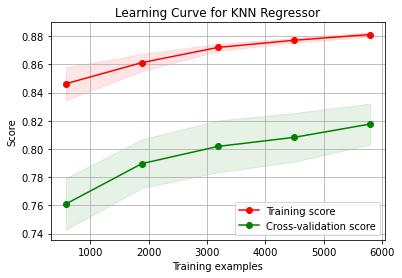

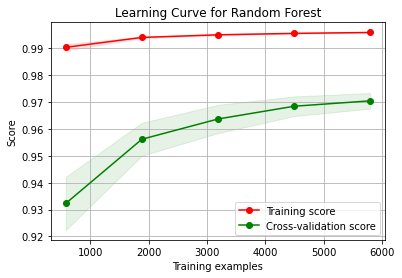

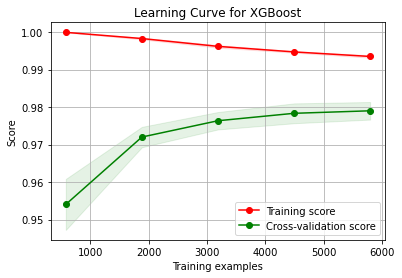

In [490]:
models_retail = {
    'KNN Regressor': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}
result_log_retail = None
result_log_retail_dicts = []
for name, model in models_retail.items():
    print(f'Currently Running Model {name}.')
    model.fit(x_train_log_retail, y_train_log_retail)
    result_log_retail_dicts.append(model_eval(model, x_test_log_retail, y_test_log_retail))
    print(f'Model {name} Finished!\n')
    skplt.estimators.plot_learning_curve(model, x_train_log_retail, y_train_log_retail, cv=10, shuffle=True, scoring='r2', n_jobs=-1, title=f'Learning Curve for {name}')
    models_retail[name] = model
for result, name in zip(result_log_retail_dicts, models_retail.keys()):
    result_log_retail = pd.concat([result_log_retail, pd.DataFrame(result, index=[name])], axis=0)
result_log_retail

From the above results, we can reach to some conclusions:
1. Model Performance: XGBoost>Random Forest>>KNN Regressor, in terms of r2 score(accuracy) and error(mse/mae). It can also be reflected in the width of CI.
2. Cross Validation: Here we take 10-fold Cross Validation for each model. The validation r2 score is approaching the training r2 score, which means there isn't much overfitting in the models. The CI of training is always narrower than that of validation, which is appropriate since the training result is more accurate.
3. For the KNN Regressor, the CI of training is rather wide, because here the accuracy isn't high enough. For the Random Forest model and XGBoost model, they both can make highly accurate prediction, so the CI of training can be narrowed down.
4. For the KNN Regressor and Random Forest, increasing the sample size can elevate training prediction accuracy, because the models aren't strong enough, so more data can help models better capture the relationship within the data. For the XGBoost model, increasing the sample size may slightly reduce training prediction accuracy, because the model is strong enough to achieve perfection for small-size data, but more data may bring some noise to the patterns it has already learned, thus interfering with the training prediction. For all the models, increasing the sample size can elevate validation prediction accuracy, because it can strengthen models' generalization ability.

#### Parameter Tuning

Since XGBoost is the model with best performance, we want to further improve its accuracy by parameter tuning.

In [492]:
param_grid = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}
xgb_regressor_retail = XGBRegressor(random_state=42)
grid_search_logretail = GridSearchCV(estimator=xgb_regressor_retail, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
grid_search_logretail.fit(x_train_log_retail, y_train_log_retail)
best_params_logretail = grid_search_logretail.best_params_

# Display the best hyperparameters
print("Best hyperparameters for XGBoost Regressor (LogRetail):", best_params_logretail)

# Build the final model with the best hyperparameters and evaluate its performance
best_grid_logretail = grid_search_logretail.best_estimator_
grid_accuracy_logretail = model_eval(best_grid_logretail, x_test_log_retail, y_test_log_retail)

# Print the evaluation metrics
print("Grid Search LogRetail Model Evaluation:", grid_accuracy_logretail)


Best hyperparameters for XGBoost Regressor (LogRetail): {'colsample_bytree': 0.8, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Grid Search LogRetail Model Evaluation: {'r2': 0.9814051605232817, 'mae': 0.12195509867027832, 'mse': 0.030263117153746254}


#### Best Model Performance

In [495]:
# Fit final model with best hyperparameters for LogRetail
xgb_final_logretail = XGBRegressor(**grid_search_logretail.best_params_, random_state=42)
xgb_final_logretail.fit(x_train_log_retail, y_train_log_retail)

# Predict results on training and test data
xgb_predict_result_final_train_logretail = xgb_final_logretail.predict(x_train_log_retail)
xgb_predict_result_final_test_logretail = xgb_final_logretail.predict(x_test_log_retail)

# Calculate R2 scores
r2_train_logretail = r2_score(y_train_log_retail, xgb_predict_result_final_train_logretail)
r2_test_logretail = r2_score(y_test_log_retail, xgb_predict_result_final_test_logretail)

# Print R2 scores
print("Final XGBoost Regressor training R2-score =", round(r2_train_logretail, 3))
print("Final XGBoost Regressor validation R2-score =", round(r2_test_logretail, 3))


Final XGBoost Regressor training R2-score = 0.99
Final XGBoost Regressor validation R2-score = 0.981


### Price Prediction Model

Here we use the logPrice for prediction.

#### Data Preparation

First we generate the X(features) and Y(label) data for train and test.

In [496]:
x_log_price = df_final.drop(columns=['id', 'Price', 'Retail', 'LogPrice', 'LogRetail', 'Profit'])
y_log_price = df_final['LogPrice']

x_train_log_price, x_test_log_price, y_train_log_price, y_test_log_price = train_test_split(x_log_price, y_log_price, test_size=ratio, random_state=100)

print(f'The shape of X_Train is {x_train_log_price.shape}.')
print(f'The shape of X_Test is {x_test_log_price.shape}.')
print(f'The shape of Y_Train is {y_train_log_price.shape}.')
print(f'The shape of Y_Test is {y_test_log_price.shape}.')

The shape of X_Train is (6440, 94).
The shape of X_Test is (1610, 94).
The shape of Y_Train is (6440,).
The shape of Y_Test is (1610,).


#### Run Models

Here we fit each model separately, and then examine their result.

Note here in the plots, 'Training Examples' mean the number of samples used for training. It reflects the impact of training sample size, and doesn't mean the training process.

Currently Running Model KNN Regressor.
Model KNN Regressor Finished!

Currently Running Model Random Forest.
Model Random Forest Finished!

Currently Running Model XGBoost.
Model XGBoost Finished!



,r2,mae,mse
KNN Regressor,0.905193,0.289829,0.140883
Random Forest,0.983541,0.106075,0.024458
XGBoost,0.990485,0.088350,0.014140


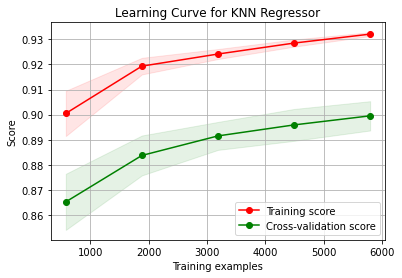

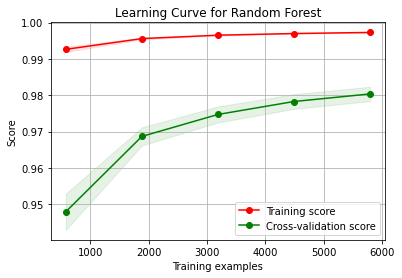

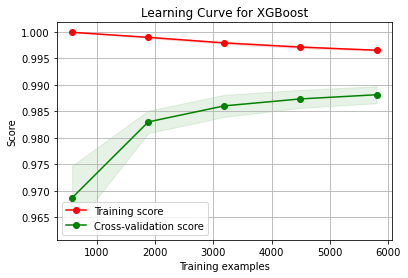

In [497]:
models_price = {
    'KNN Regressor': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}
result_log_price = None
result_log_price_dicts = []
for name, model in models_price.items():
    print(f'Currently Running Model {name}.')
    model.fit(x_train_log_price, y_train_log_price)
    result_log_price_dicts.append(model_eval(model, x_test_log_price, y_test_log_price))
    print(f'Model {name} Finished!\n')
    skplt.estimators.plot_learning_curve(model, x_train_log_price, y_train_log_price, cv=10, shuffle=True, scoring='r2', n_jobs=-1, title=f'Learning Curve for {name}')
    models_price[name] = model
for result, name in zip(result_log_price_dicts, models_price.keys()):
    result_log_price = pd.concat([result_log_price, pd.DataFrame(result, index=[name])], axis=0)
result_log_price

#### Parameter Tuning

Since XGBoost is the model with best performance, we want to further improve its accuracy by parameter tuning.

In [ ]:
param_grid = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}
xgb_regressor_price = XGBRegressor(random_state=42)
grid_search_logprice = GridSearchCV(estimator=xgb_regressor_price, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
grid_search_logprice.fit(x_train_log_price, y_train_log_price)
best_params_logprice = grid_search_logprice.best_params_

# Display the best hyperparameters
print("Best hyperparameters for XGBoost Regressor (LogPrice):", best_params_logprice)

# Build the final model with the best hyperparameters and evaluate its performance
best_grid_logprice = grid_search_logprice.best_estimator_
grid_accuracy_logprice = model_eval(best_grid_logprice, x_test_log_price, y_test_log_price)

# Print the evaluation metrics
print("Grid Search LogPrice Model Evaluation:", grid_accuracy_logprice)


In [499]:
# Fit final model with best hyperparameters for LogPrice
# xgb_final_logprice = XGBRegressor(**grid_search_logprice.best_params_, random_state=42)
xgb_final_logprice = models_price['XGBoost']
xgb_final_logprice.fit(x_train_log_price, y_train_log_price)

# Predict results on training and test data
xgb_predict_result_final_train_logprice = xgb_final_logprice.predict(x_train_log_price)
xgb_predict_result_final_test_logprice = xgb_final_logprice.predict(x_test_log_price)

# Calculate R2 scores
r2_train_logprice = r2_score(y_train_log_price, xgb_predict_result_final_train_logprice)
r2_test_logprice = r2_score(y_test_log_price, xgb_predict_result_final_test_logprice)

# Print R2 scores
print("Final XGBoost Regressor training R2-score =", round(r2_train_logprice, 3))
print("Final XGBoost Regressor validation R2-score =", round(r2_test_logprice, 3))


Final XGBoost Regressor training R2-score = 0.996
Final XGBoost Regressor validation R2-score = 0.99


### Data Prediction in the Testing Dataset

In [505]:
# Predict Price
features = x_log_retail.columns
df_new_final['pred_log_price'] = xgb_final_logprice.predict(df_new_final[features])
df_new_final['pred_price'] = df_new_final['pred_log_price'].apply(lambda x: np.exp(x))
# Predict Retail
df_new_final['pred_log_retail'] = xgb_final_logretail.predict(df_new_final[features])
df_new_final['pred_retail'] = df_new_final['pred_log_retail'].apply(lambda x: np.exp(x))
# Calculate Profit & ROI
df_new_final['pred_profit'] = df_new_final['pred_retail'] - df_new_final['pred_price']
df_new_final['ROI'] = round((df_new_final['pred_retail'] - df_new_final['pred_price']) * 100 / df_new_final['pred_price'], 2)
# Sort by ROI
df_new_final = df_new_final.sort_values(by='ROI', ascending=False)
# Display Data
display(df_new_final[['id', 'pred_log_price', 'pred_log_retail', 'pred_price', 'pred_retail', 'pred_profit','ROI']])

,id,pred_log_price,pred_log_retail,pred_price,pred_retail,pred_profit,ROI
849,8900,8.564764,9.368443,5243.602404,11712.869682,6469.267278,123.37
1442,9493,8.243580,9.014528,3803.130660,8221.667074,4418.536414,116.18
1651,9702,8.444710,9.201457,4650.405866,9911.559920,5261.154054,113.13
722,8773,8.709945,9.464571,6062.907352,12894.691566,6831.784214,112.68
819,8870,8.727866,9.466732,6172.542909,12922.587461,6750.044552,109.36
...,...,...,...,...,...,...,...
1143,9194,9.676664,7.603709,15941.233805,2005.620452,-13935.613353,-87.42
2508,10559,10.116146,8.013247,24739.243999,3020.710930,-21718.533069,-87.79
2240,10291,10.048692,7.923604,23125.513085,2761.707670,-20363.805415,-88.06
1749,9800,9.505569,7.362713,13434.340854,1576.106525,-11858.234329,-88.27


## Diamonds Selection

### ROI Selection

Here we consider diamonds with higher ROI in priority.

In [566]:
df_roi = df_new_final.copy()
df_roi = df_roi[['id', 'pred_log_price', 'pred_log_retail', 'pred_price', 'pred_retail', 'pred_profit','ROI']]
df_roi['sum_to_now'] = df_roi['pred_price'].cumsum()
df_roi['offer'] = np.where(df_roi['sum_to_now'] <= 5000000, df_roi['pred_price'], 0)  # If still below 5000000, take it! Else, give up!
df_roi_eff = df_roi[df_roi['offer'] > 0]
print(f'The total number of diamonds selected by ROI is {len(df_roi_eff)}.')
total = df_roi_eff['sum_to_now'].max()
print(f'The total price equals to {round(total, 0)}, with {round(5000000 - total, 0)} left.')
total_profit = sum(df_roi_eff['pred_profit'])
print(f'The total predict profit equals to {round(total_profit, 0)}, with an estimated total ROI of {round(total_profit / 5000000 * 100, 2)}%.')

The total number of diamonds selected by ROI is 600.
The total price equals to 4998850.0, with 1150.0 left.
The total predict profit equals to 3768188.0, with an estimated total ROI of 75.36%.


Here are some money left, we should see if we can use it up.

In [567]:
df_roi_rest = df_roi[df_roi['offer'] == 0]
df_roi_rest = df_roi_rest[df_roi_rest['pred_price'] <= 5000000 - total]
df_roi_rest = df_roi_rest.sort_values(by='pred_profit', ascending=False)
df_roi_rest['sum_to_now'] = np.zeros(len(df_roi_rest))
df_roi_rest['sum_to_now'] = df_roi_rest['pred_price'].cumsum()
df_roi_rest['offer'] = np.where(df_roi_rest['sum_to_now'] <= 5000000 - total, df_roi_rest['pred_price'], 0)
df_roi_rest_eff = df_roi_rest[df_roi_rest['offer'] > 0]
display(df_roi_rest_eff)
print(f'The total number of diamonds selected by ROI is {len(df_roi_eff) + len(df_roi_rest_eff)}.')
total = df_roi_eff['sum_to_now'].max() + sum(df_roi_rest_eff['pred_price'])
print(f'The total price equals to {round(total, 0)}, with {round(5000000 - total, 0)} left.')
total_profit = sum(df_roi_eff['pred_profit']) + sum(df_roi_rest_eff['pred_profit'])
print(f'The total predict profit equals to {round(total_profit, 0)}, with an estimated total ROI of {round(total_profit / 5000000 * 100, 2)}%.')
roi_dict = {'Number of Diamonds': len(df_roi_eff) + len(df_roi_rest_eff),
            'Total Price': total,
            'Budget Left': 5000000 - total,
            'Usage Percent': f'{round(total / 5000000 * 100, 4)}%',
            'Total Profit': total_profit,
            'Total ROI': f'{round(total_profit / 5000000 * 100, 2)}%'}
df_roi_final = pd.concat([df_roi_eff, df_roi_rest_eff], axis=0)[['id', 'pred_price', 'pred_retail', 'pred_profit']]
df_roi_final

,id,pred_log_price,pred_log_retail,pred_price,pred_retail,pred_profit,ROI,sum_to_now,offer
222,8273,7.0,7.5,1128.0,1857.3,729.3,64.7,1128.0,1128.0


The total number of diamonds selected by ROI is 601.
The total price equals to 4999978.0, with 22.0 left.
The total predict profit equals to 3768917.0, with an estimated total ROI of 75.38%.


,id,pred_price,pred_retail,pred_profit
849,8900,5243.6,11712.9,6469.3
1442,9493,3803.1,8221.7,4418.5
1651,9702,4650.4,9911.6,5261.2
722,8773,6062.9,12894.7,6831.8
819,8870,6172.5,12922.6,6750.0
...,...,...,...,...
1328,9379,5272.3,8738.1,3465.8
28,8079,795.3,1318.0,522.7
389,8440,2425.4,4018.2,1592.8
1772,9823,8165.3,13524.5,5359.2


### Profit Selection

Here we consider diamonds with higher Profit in priority.

In [568]:
df_profit = df_new_final.copy()
df_profit = df_profit.sort_values(by='pred_profit', ascending=False)
df_profit = df_profit[['id', 'pred_log_price', 'pred_log_retail', 'pred_price', 'pred_retail', 'pred_profit','ROI']]
df_profit['sum_to_now'] = df_profit['pred_price'].cumsum()
df_profit['offer'] = np.where(df_profit['sum_to_now'] <= 5000000, df_profit['pred_price'], 0)  # If still below 5000000, take it! Else, give up!
df_profit_eff = df_profit[df_profit['offer'] > 0]
print(f'The total number of diamonds selected by Profit is {len(df_profit_eff)}.')
total = df_profit_eff['sum_to_now'].max()
print(f'The total price equals to {round(total, 0)}, with {round(5000000 - total, 0)} left.')
total_profit = sum(df_profit_eff['pred_profit'])
print(f'The total predict profit equals to {round(total_profit, 0)}, with an estimated total ROI of {round(total_profit / 5000000 * 100, 2)}%.')

The total number of diamonds selected by Profit is 50.
The total price equals to 4975807.0, with 24193.0 left.
The total predict profit equals to 2398895.0, with an estimated total ROI of 47.98%.


Here are some money left, we should see if we can use it up.

In [569]:
df_profit_rest = df_profit[df_profit['offer'] == 0]
df_profit_rest = df_profit_rest[df_profit_rest['pred_price'] <= 5000000 - total]
df_profit_rest = df_profit_rest.sort_values(by='pred_profit', ascending=False)
df_profit_rest['sum_to_now'] = np.zeros(len(df_profit_rest))
df_profit_rest['sum_to_now'] = df_profit_rest['pred_price'].cumsum()
df_profit_rest['offer'] = np.where(df_profit_rest['sum_to_now'] <= 5000000 - total, df_profit_rest['pred_price'], 0)
df_profit_rest_eff = df_profit_rest[df_profit_rest['offer'] > 0]
display(df_profit_rest_eff)
print(f'The total number of diamonds selected by ROI is {len(df_profit_eff) + len(df_profit_rest_eff)}.')
total = df_profit_eff['sum_to_now'].max() + sum(df_profit_rest_eff['pred_price'])
print(f'The total price equals to {round(total, 0)}, with {round(5000000 - total, 0)} left.')
total_profit = sum(df_profit_eff['pred_profit']) + sum(df_profit_rest_eff['pred_profit'])
print(f'The total predict profit equals to {round(total_profit, 0)}, with an estimated total ROI of {round(total_profit / 5000000 * 100, 2)}%.')
profit_dict = {'Number of Diamonds': len(df_profit_eff) + len(df_profit_rest_eff),
            'Total Price': total,
            'Budget Left': 5000000 - total,
            'Usage Percent': f'{round(total / 5000000 * 100, 4)}%',
            'Total Profit': total_profit,
            'Total ROI': f'{round(total_profit / 5000000 * 100, 2)}%'}
df_profit_final = pd.concat([df_profit_eff, df_profit_rest_eff], axis=0)[['id', 'pred_price', 'pred_retail', 'pred_profit']]
df_profit_final

,id,pred_log_price,pred_log_retail,pred_price,pred_retail,pred_profit,ROI,sum_to_now,offer
1183,9234,10.1,10.7,23854.0,42898.2,19044.1,79.8,23854.0,23854.0


The total number of diamonds selected by ROI is 51.
The total price equals to 4999661.0, with 339.0 left.
The total predict profit equals to 2417939.0, with an estimated total ROI of 48.36%.


,id,pred_price,pred_retail,pred_profit
1321,9372,233417.3,385498.8,152081.4
2380,10431,166167.2,306934.9,140767.6
1317,9368,267600.8,379944.4,112343.6
2307,10358,115917.1,227595.5,111678.4
1320,9371,182685.2,276788.2,94103.0
1313,9364,189652.1,279413.5,89761.5
1352,9403,180137.7,260681.1,80543.4
1322,9373,155229.7,228651.1,73421.3
2314,10365,208173.1,275819.0,67645.9
1312,9363,156553.9,211325.1,54771.2


### Selection Comparison

In [570]:
df_roi_res = pd.DataFrame(roi_dict, index=['ROI'])
df_profit_res = pd.DataFrame(profit_dict, index=['Profit'])
df_compare = pd.concat([df_roi_res, df_profit_res], axis=0)
df_compare

,Number of Diamonds,Total Price,Budget Left,Usage Percent,Total Profit,Total ROI
ROI,601,4999978.2,21.8,99.9996%,3768917.4,75.38%
Profit,51,4999660.7,339.3,99.9932%,2417939.3,48.36%


From the result we can see that ROI Selection has a significantly higher total profit than Profit Selection, with less money left.

This can be used as a useful strategies for selecting diamonds given a fixed total budget.

## Answer Questions

### Question 1

Do you think that any of the vendors are over or under charging for diamonds compared to the other vendors? Do you think they are selling the same kind of diamonds? How did you come to this conclusion?

First we use the model to predict the price of the training dataset.

In [574]:
# Predict Price
features = x_log_retail.columns
df_final['pred_log_price'] = xgb_final_logprice.predict(df_final[features])
df_final['pred_price'] = df_final['pred_log_price'].apply(lambda x: np.exp(x))
# Predict Retail
df_final['pred_log_retail'] = xgb_final_logretail.predict(df_final[features])
df_final['pred_retail'] = df_final['pred_log_retail'].apply(lambda x: np.exp(x))
# Calculate Profit & ROI
df_final['pred_profit'] = df_final['pred_retail'] - df_final['pred_price']
df_final['ROI'] = round((df_final['pred_retail'] - df_final['pred_price']) * 100 / df_final['pred_price'], 2)
# Display Data
display(df_final[['id', 'pred_log_price', 'pred_log_retail', 'pred_price', 'pred_retail', 'pred_profit','ROI']])

,id,pred_log_price,pred_log_retail,pred_price,pred_retail,pred_profit,ROI
5405,5406,7.9,8.8,2578.3,6874.5,4296.2,166.6
2071,2072,8.3,9.2,4113.9,9894.4,5780.6,140.5
7997,7998,8.4,9.2,4243.2,10105.1,5861.9,138.2
1283,1284,7.5,8.3,1767.5,4106.5,2339.0,132.3
3807,3808,10.3,11.1,28717.6,65705.2,36987.5,128.8
...,...,...,...,...,...,...,...
2722,2723,9.2,6.8,9701.2,883.5,-8817.7,-90.9
523,524,6.2,3.8,498.3,44.8,-453.5,-91.0
3551,3552,9.7,7.3,16530.9,1469.5,-15061.4,-91.1
3476,3477,9.5,7.0,13517.5,1131.6,-12385.9,-91.6


Then we join the original data and predict result together.

Here a positive 'price_diff' means that the vendor sells the diamond more expensive than prediction.

In [583]:
df_total = df.merge(df_final[['id', 'pred_log_price', 'pred_log_retail', 'pred_price', 'pred_retail', 'pred_profit','ROI']], on=['id'], how='left')
df_total['price_diff'] = df_total['Price'] - df_total['pred_price']
df_group = df_total[['Vendor', 'price_diff']].groupby(by='Vendor').agg(['mean', 'std'])
df_group

price_diff       
             mean    std
Vendor                  
1            16.0  235.2
2           317.0 5552.0
3            39.1  939.3
4            71.5 1573.0

From the result, we can see that Vendor 2 may tend to overcharge.

### Question 2

What is the relationship between Carat and Retail Price? Why do you think the relationship takes this form?

In [584]:
# Calculate and display the correlations
carats_price_corr = round(df['Carats'].corr(df['Price']), 4)
carats_retail_corr = round(df['Carats'].corr(df['Retail']), 4)
carats_profit_corr = round(df['Carats'].corr(df['Profit']), 4)

print(f"Correlation between Carats and Price: {carats_price_corr}")
print(f"Correlation between Carats and Retail: {carats_retail_corr}")
print(f"Correlation between Carats and Profit: {carats_profit_corr}")


Correlation between Carats and Price: 0.7413
Correlation between Carats and Retail: 0.7163
Correlation between Carats and Profit: 0.5137


From the result we can see that Carats are significantly and positively correlated to Profit/Retail/Price, since the heavier/bigger the diamond is, the more it will worths.